In [46]:
## Load libraries
! pip3 install POT

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import wasserstein_distance as wd
import ot
import torch
from torch import nn, optim
from scipy.optimize import curve_fit
from lib.collision_wrapper import find_OT_ISA as ISA
from lib.collision_wrapper import find_OT_collision as newot

rng = np.random.seed(0)
size = 7;
cm = 0.393701; #inches
markers = ["o", "s", "<", ">", "d", "+"]
cls = ["blue", "red", "green", "m", "c", "brown", "gray", "salmon", "blueviolet", "lime", "chocolate"]

In [47]:
def find_optimal_map_nd(X0, Y0, numItermax=10000000):
  # X, Y with dim (Np, dim)
  n = X0.shape[0]
  a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

  # loss matrix
  M = ot.dist(X0, Y0)

  G0 = ot.emd(a, b, M, numItermax=numItermax)

  index_X = np.argmax(G0, axis=1)
  #index_Y = np.argmax(G0, axis=0)

  return X0, Y0[index_X]

def find_sinkhorn_map_nd(X0, Y0, lambd = 1e-3, numItermax=10000000):
  # X, Y with dim (Np, dim)
  n = X0.shape[0]
  a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

  # loss matrix
  M = ot.dist(X0, Y0)

  G0 = ot.sinkhorn(a, b, M, reg=lambd, numItermax=numItermax)

  index_X = np.argmax(G0, axis=1)
  #index_Y = np.argmax(G0, axis=0)

  return X0, Y0[index_X]

In [68]:
from numpy.random import default_rng

rng = default_rng()

def find_OT_collision_nd_nmargins_new(x, Total_Cost, Change_Cost, MinIter=20, MaxIter=100000, tol = 1e-3, avg_window=20, ISvectorized=True):
    # x with size (Nmargins, N, dim)
    Nm = x.shape[0] # number of margins
    Np = x.shape[1] # number of samples per margin
    tries = Np
    sum_ = 1000000
    ids = np.array([[i for i in range(Np)] for j in range(Nm)]) # Nmargines, Np

    dists_coll = [Total_Cost(x, ids)]

    Jt = [np.mean(x[0,:,:]*x[1,:,:])]
    for nt in range(1, MaxIter+1):
        for k in range(Nm):
            iss = rng.choice(Np, size=tries, replace=False)
            i1s = iss[:int(tries/2)]
            i2s = iss[int(tries/2):]

            if ISvectorized is True:
              s0 = Change_Cost(x, ids, i1s, i2s, k, before=True)
              s1 = Change_Cost(x, ids, i1s, i2s, k, before=False)

              # Determine which swaps to accept
              mask = s1 < s0

              # Perform the swaps for accepted cases
              accepted_i1s = i1s[mask]
              accepted_i2s = i2s[mask]

              x[k,accepted_i1s,:], x[k,accepted_i2s,:] = x[k,accepted_i2s,:].copy(), x[k,accepted_i1s,:].copy()
            else:
              for jj in range(int(Np/2)):
                #print("-- test")
                s0 = Change_Cost(x, ids, i1s, i2s, k, before=True, ISvectorized=False)[0]
                s1 = Change_Cost(x, ids, i1s, i2s, k, id_m=[jj], before=False, ISvectorized=False)[0]
                if s1 < s0:
                  #print("-- accept")
                  temp = x[k, i1s[jj], :].copy()
                  x[k, i1s[jj], :] = x[k, i2s[jj], :].copy()
                  x[k, i2s[jj], :] = temp.copy()
                  #snew = Change_Cost(x, ids, i1s, i2s, k, before=True, ISvectorized=False)[0]
                  #print("s0:", s0, "s1:", s1, "snew", snew)


        cost = Total_Cost(x, ids)
        #print(cost)
        dists_coll.append( cost )
        Jt.append( np.mean(x[0,:,:]*x[1,:,:]) )
        
        if nt>avg_window and nt > MinIter:
            sum_0 = np.sum(np.array(dists_coll)[-avg_window:])
            if abs(sum_ - sum_0)/sum_0 < tol:
              break
            sum_ = sum_0


    return x, ids, dists_coll, nt, np.array(Jt)

def total_cost(x_m, ids_m):
  Nm_m = x_m.shape[0]
  Np_m = x_m.shape[1]
  y = 0
  for i in range(Nm_m):
    for j in range(i+1, Nm_m):
        y += np.sum( np.sum( (x_m[i, :, :]-x_m[j, :, :])**2 , axis=1) )
  return y/Np_m

def change_cost(x_m, ids_m, i1s_m, i2s_m, k_m, before=True):
  Nm_m = x_m.shape[0]
  s_m = np.ones(len(i1s_m))
  for j_m in range(Nm_m):
    if j_m != k_m:
        #s_m += np.sum( np.sum( (x_m[j_m,ids_m[j_m,:],:]-x_m[k_m,ids_m[k_m,:],:])**2, axis=1) )
        s_m += np.sum( np.sum( (x_m[j_m,:,:]-x_m[k_m,:,:])**2, axis=1) )

        if before is False:
          #s_m -= np.sum( (x_m[j_m,ids_m[j_m,i1s_m],:]-x_m[k_m,ids_m[k_m,i1s_m],:])**2, axis=1)
          #s_m -= np.sum( (x_m[j_m,ids_m[j_m,i2s_m],:]-x_m[k_m,ids_m[k_m,i2s_m],:])**2, axis=1)
          #s_m += np.sum( (x_m[j_m,ids_m[j_m,i1s_m],:]-x_m[k_m,ids_m[k_m,i2s_m],:])**2, axis=1)
          #s_m += np.sum( (x_m[j_m,ids_m[j_m,i2s_m],:]-x_m[k_m,ids_m[k_m,i1s_m],:])**2, axis=1)

          s_m -= np.sum( (x_m[j_m,i1s_m,:]-x_m[k_m,i1s_m,:])**2, axis=1)
          s_m -= np.sum( (x_m[j_m,i2s_m,:]-x_m[k_m,i2s_m,:])**2, axis=1)
          s_m += np.sum( (x_m[j_m,i1s_m,:]-x_m[k_m,i2s_m,:])**2, axis=1)
          s_m += np.sum( (x_m[j_m,i2s_m,:]-x_m[k_m,i1s_m,:])**2, axis=1)

  return s_m


# Learning multi-marginal map

In [48]:
def swissroll(n=1000, noise=0.5):
    """
    Generate samples of a Swiss roll dataset.

    Parameters:
    n (int)     : Number of points to generate (default: 1000)
    noise (float): Amount of Gaussian noise to add (default: 0.05)

    Returns:
    X (ndarray)  : An n x 2 matrix, where each row is a point (x, y) in 2D space
    color (ndarray): A vector of values corresponding to the angle (theta), useful for coloring
    """
    # Generate random values for the angle (theta) and height (z)
    theta = (3 * np.pi / 2) * (1 + 2 * np.random.rand(n, 1))  # Angle (theta) values for the spiral

    # Generate the (x, y) coordinates
    x = theta * np.cos(theta)
    y = theta * np.sin(theta)

    # Add Gaussian noise
    x += noise * np.random.randn(n, 1)
    y += noise * np.random.randn(n, 1)

    # Combine the coordinates into a matrix X
    X = np.hstack((x / 5., y / 5.))  # Dividing by 5 to match the scale

    return X

def sample_banana(Np):
    x1 = np.random.normal(0,1,(Np,1))
    x2 = x1**2 + np.random.normal(0,1,(Np,1))
    return np.concatenate([x1,x2], axis=1)

In [49]:
class Funnel:
    """
    Defines a multivariate distribution with 2 dimensions that
    have a funnel shape and d-2 dimensional Gaussian components.

    Author:
    Date:   September 2019
    """

    def __init__(self, d, sigma=2.0, limit_min=0.0, limit_max=10.0):
        """
        Initializes the Funnel object.

        Parameters:
        d (int): Dimension of distribution (must be at least 2)
        sigma (float): Standard deviation of the density (default: 2.0)
        limit_min (float): Minimum limit for threshold (default: 0.0)
        limit_max (float): Maximum limit for threshold (default: 10.0)
        """

        if d < 2:
            raise ValueError('Funnel: dimension must be at least 2')

        self.d = d
        self.sigma = sigma
        self.limit_min = limit_min
        self.limit_max = limit_max
        self.name = 'funnel'

    def sample(self, N):
        """
        Samples from the funnel distribution.

        Parameters:
        N (int): Number of samples.

        Returns:
        numpy.ndarray: Samples from the distribution.
        """
        X = np.random.randn(N, self.d)
        X[:, 0] = self.sigma * X[:, 0]
        for i in range(1, self.d):
            X[:, i] = X[:, i] * np.sqrt(self.threshold(X[:, 0]))
        return X

    def threshold(self, x):
        """
        Applies the threshold function to a given value.

        Parameters:
        x (numpy.ndarray): Input array.

        Returns:
        numpy.ndarray: Thresholded values.
        """
        v = np.exp(-x)
        v = np.clip(v, self.limit_min, self.limit_max)
        return v

    def log_pdf(self, X):
        """
        Computes the log of the probability density function.

        Parameters:
        X (numpy.ndarray): Input samples.

        Returns:
        numpy.ndarray: Logarithm of the PDF evaluated at X.
        """
        if X.shape[1] != self.d:
            raise ValueError('Funnel: dimension mismatch for input samples')

        # Log PDF for the first dimension
        log_pi = self.norm_log_pdf(X[:, 0], 0, self.sigma)

        # Log PDF for the remaining dimensions
        for i in range(1, self.d):
            v = self.threshold(X[:, 0])
            log_pi += self.norm_log_pdf(X[:, i], 0, np.sqrt(v))

        return log_pi

    @staticmethod
    def norm_log_pdf(X, mean, sigma):
        """
        Computes the log of the normal probability density function.

        Parameters:
        X (numpy.ndarray): Input samples.
        mean (float): Mean of the distribution.
        sigma (float): Standard deviation of the distribution.

        Returns:
        numpy.ndarray: Logarithm of the normal PDF evaluated at X.
        """
        return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((X - mean)**2 / sigma**2)

In [50]:
class Ring:
    def __init__(self, d, sigma=0.2, radia=5.0):
        """
        Defines a d-dimensional distribution with two components lying along a ring
        and (d-2) Gaussian components.
        
        :param d: Dimension of distribution
        :param sigma: Standard deviation of density (default: 0.2)
        :param radia: Radial parameter of distribution (default: 5.0)
        """
        if d < 2:
            raise ValueError('Ring: dimension must be at least 2')

        self.d = d
        self.sigma = sigma
        
        # Ensure radia is always a numpy array, even if it's a scalar
        if np.isscalar(radia):
            self.radia = np.array([radia])
        else:
            self.radia = np.array(radia)

        self.name = 'ring'

    def sample(self, N):
        """
        Samples N points from the distribution.

        :param N: Number of samples
        :return: A sample array of size (N, d)
        """
        # Draw angles and noise
        angles = np.random.rand(N) * 2 * np.pi
        noise = np.random.randn(N) * self.sigma

        # Compute weights
        weights = 2 * np.pi * self.radia
        weights = weights / np.sum(weights)

        # Sample from possible radia vector
        radia_idx = np.random.choice(len(self.radia), N, p=weights)
        radius_samples = self.radia[radia_idx] + noise

        # Compute points in first two dimensions (X and Y)
        xs = radius_samples * np.sin(angles)
        ys = radius_samples * np.cos(angles)
        X = np.column_stack([xs, ys])

        # Append independent Gaussian directions for d > 2
        if self.d > 2:
            gauss_noise = self.sigma * np.random.randn(N, self.d - 2)
            X = np.column_stack([X, gauss_noise])

        return X
    def log_pdf(self, X):
        """
        Evaluates the log-probability density function for the given samples X.

        :param X: Input samples of shape (N, d)
        :return: Log-probabilities of shape (N,)
        """
        if X.shape[1] != self.d:
            raise ValueError('Ring: dimension mismatch for input samples')

        # Compute weights
        weights = 2 * np.pi * self.radia
        weights = weights / np.sum(weights)

        # Compute norms in the first two directions
        norms = np.sqrt(np.sum(X[:, :2] ** 2, axis=1))

        # Compute log_pi for the first two dimensions
        log_pi = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            log_pdf_ring_comps = -0.5 * ((norms[i] - self.radia) ** 2) / (self.sigma ** 2) - \
                                 0.5 * np.log(2 * np.pi * self.sigma ** 2) - \
                                 np.log(2 * np.pi * self.radia)
            log_pi[i] = self.log_sum_exp(log_pdf_ring_comps + np.log(weights))

        # Add the log_pdf for the remaining Gaussian directions (if d > 2)
        if self.d > 2:
            for i in range(2, self.d):
                log_pi += self.norm_log_pdf(X[:, i], 0, self.sigma)

        return log_pi

    def log_sum_exp(self, X):
        """
        Evaluates log-sum-exp for a vector X.

        :param X: Input vector
        :return: log(sum(exp(X)))
        """
        X_min = np.min(X)
        X_without_min = np.delete(X, np.argmin(X))

        # Compute log-sum-exp
        return X_min + np.log(1 + np.sum(np.exp(X_without_min - X_min)))

    def norm_log_pdf(self, X, mean, sigma):
        """
        Evaluates the log of a normal probability density function.

        :param X: Input data
        :param mean: Mean of the normal distribution
        :param sigma: Standard deviation of the normal distribution
        :return: Log-probability of the input data
        """
        return -0.5 * np.log(2 * np.pi * sigma ** 2) - 0.5 / (sigma ** 2) * (X - mean) ** 2

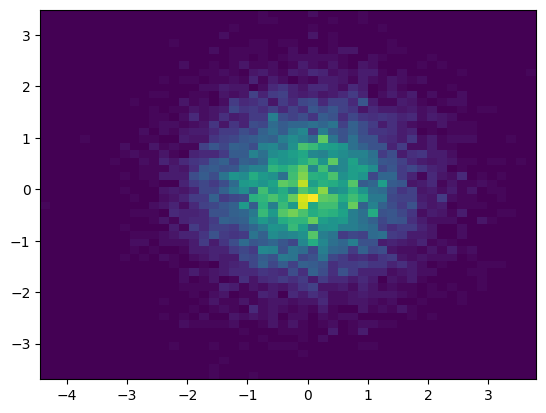

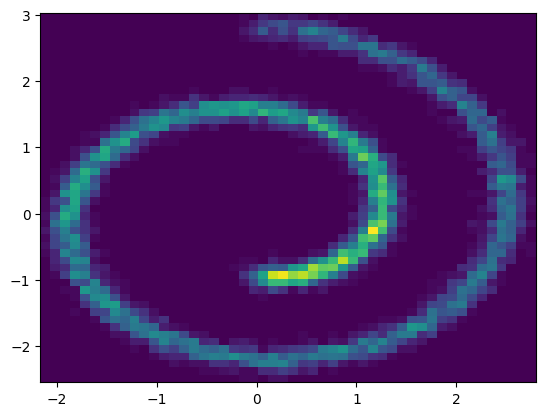

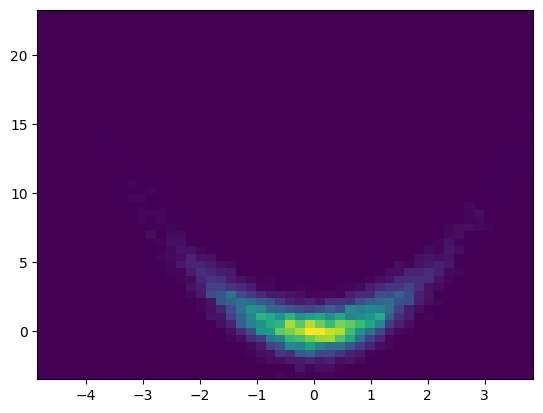

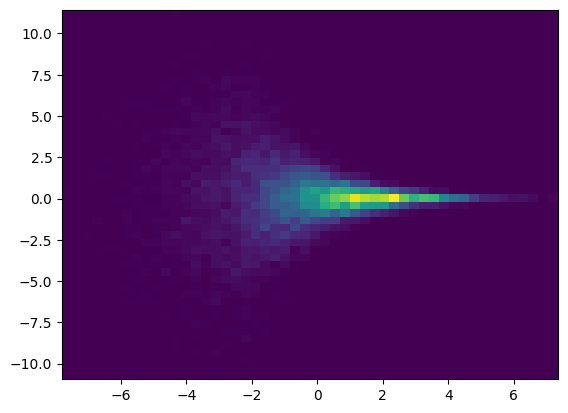

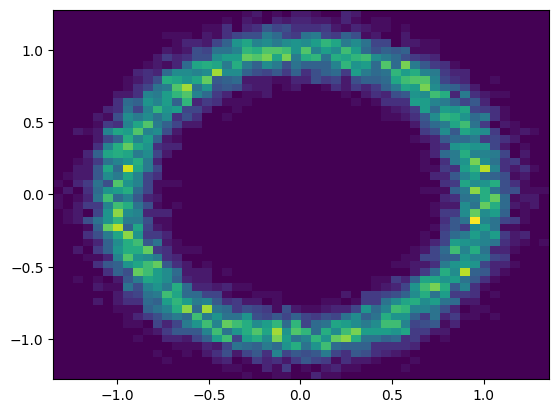

In [51]:
def generate_5marginals(Np, seed=0):
    dim=2; 
    Nm=5;
    #normal
    nr = np.random.normal(0,1,(Np,dim))

    #swiss roll
    sr = swissroll(Np)

    #banana
    bn = sample_banana(Np)

    #funnel
    funnel = Funnel(d=2,sigma=2)
    fn = funnel.sample(Np)

    #ring
    ring = Ring(d=2,sigma=0.1, radia=1.0)
    rg = ring.sample(Np)

    X = np.zeros((Nm,Np,dim))
    X[0,:,:] = nr;
    X[1,:,:] = sr;
    X[2,:,:] = bn;
    X[3,:,:] = fn;
    X[4,:,:] = rg;
    return X, Nm, dim

Np = 10**4 # number of points/particles/samples
X, Nm, dim = generate_5marginals(Np)

X00 = X.copy()

for i in range(Nm):
    plt.figure()
    _ = plt.hist2d(X[i,:,0], X[i,:,1], bins=50)

In [84]:
import time
from lib.collision_wrapper import find_OT_collision as newot
import tracemalloc
tracemalloc.start()

Nps = [1000, 2000, 4000, 8000, 16000]

navg = 4
times = [0 for i in range(len(Nps))]
mems = [0 for i in range(len(Nps))]
w2s = [[[] for k in range(navg)] for i in range(len(Nps))]

times_isa = [0 for i in range(len(Nps))]
mems_isa = [0 for i in range(len(Nps))]
w2s_isa = [[[] for k in range(navg)] for i in range(len(Nps))]
for j in range(len(Nps)):
    Np = Nps[j]
    m = 0
    t = 0
    m_isa = 0
    t_isa = 0
    for k in range(navg):
        tracemalloc.reset_peak()
        first_size, first_peak = tracemalloc.get_traced_memory()
        
        X0, Nm, dim = generate_5marginals(Np, seed=k)
        
        X = X0.copy()
        start_time = time.time()
        X, dists_coll_xy, nt = newot(X, MinIter=3000, MaxIter=3000, tol = 1e-9, avg_window=20, Track=1)
        t += time.time() - start_time
        first_size, second_peak = tracemalloc.get_traced_memory()
        m += second_peak - first_peak
        w2s[j][k] = dists_coll_xy
        del X, dists_coll_xy

        X = X0.copy()
        start_time = time.time()
        X, dists_coll_xy, nt = ISA(X, MinIter=6, MaxIter=6, tol = 1e-3, avg_window=1, Track=1)
        t_isa += time.time() - start_time
        first_size, second_peak = tracemalloc.get_traced_memory()
        m_isa += second_peak - first_peak
        w2s_isa[j][k] = dists_coll_xy
        del X, dists_coll_xy

    mems[j] = m/(1.*navg)
    times[j] = t/(1.*navg)
    mems_isa[j] = m_isa/(1.*navg)
    times_isa[j] = t_isa/(1.*navg)
    print(r"Np:", Np, flush=True)

Np: 1000
Np: 2000
Np: 4000
Np: 8000
Np: 16000


In [87]:
Nm

5

/tmp/ipykernel_11295/948483813.py:74: RuntimeWarning: overflow encountered in exp
  return a*(np.exp(b*(x-1)**0.5)-1.) + mean[0]
/tmp/ipykernel_11295/948483813.py:74: RuntimeWarning: overflow encountered in multiply
  return a*(np.exp(b*(x-1)**0.5)-1.) + mean[0]
/tmp/ipykernel_11295/948483813.py:78: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(exponential_function, x, y, p0=initial_guess)


54.183793368835495 -0.3380394018701235 0.0


'\nfig, ax = plt.subplots();\ncls = ["blue", "red", "green", "m", "c", "brown", "gray", "salmon", "blueviolet", "lime", "chocolate"]\nmarkers=["o", "s", "d", "<", "^"]\nw2s = np.array(w2s)\nfor j in range(len(Nps)):\n    mean = abs( np.mean(w2s[j,:,:1000], axis=0) - dists0[-1] )\n    std = np.std(w2s[j,:,1000], axis=0)\n    ax.plot(mean, color=cls[j], linewidth=1, label=r"$N_p=$"+str(Nps[j]), marker=markers[j], markevery=50+10*j, markersize=4)\n    #plt.fill_between([i for i in range(mean.shape[0])], mean/mean[0]-std, mean/mean[0]+std, color=cls[j], alpha=0.2)\nplt.legend()\nax.set_xscale("log")\nax.set_yscale("log")\n#ax.set_xticks([10,100],[r\'$10$\',r\'$10^2$\'])\n#ax.set_xlim([100,40000])\nax.set_xlabel(r"Iteration")\nax.set_ylabel(r\'$d^2(x_t)$\')\n#ax.set_ylabel(r\'${\\sum_{i\neq j} \\mathbb{E}[||x_t^{(i)}-x_t^{(j)}||_2^2]}/{\\sum_{i\neq j} \\mathbb{E}[||x_0^{(i)}-x_0^{(j)}||_2^2]}$\')\n#ax.legend(loc=\'center left\', bbox_to_anchor=(1, 0.5))\n\nfig.set_size_inches(size*cm, size*

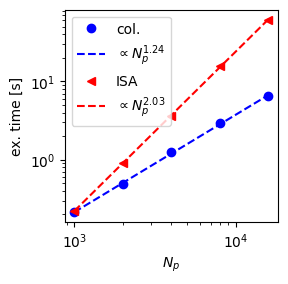

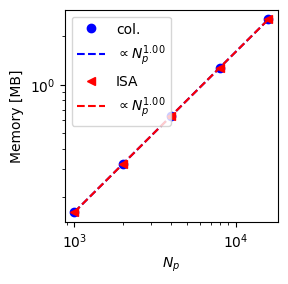

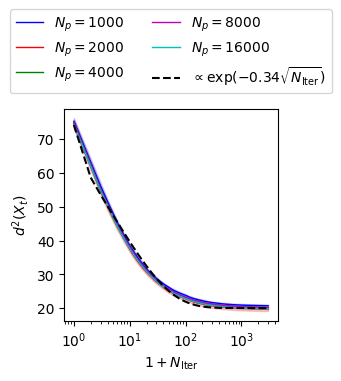

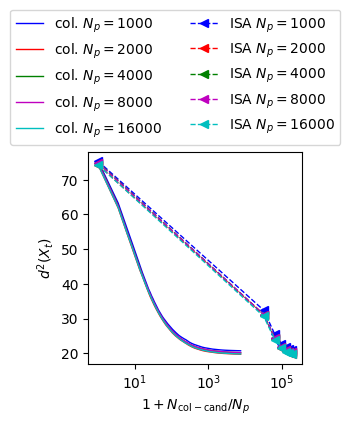

In [96]:
from scipy.stats import linregress
from scipy.optimize import curve_fit

def fit_xp(x, y):
    log_x = np.log10(x)
    log_y = np.log10(y)

    slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
    slope_str = f'{slope:.2f}'

    fitted_y = 10**(intercept + slope * log_x)
    return slope, slope_str, fitted_y

fig, ax = plt.subplots();

ax.plot(Nps, times, marker="o", color="blue", linewidth=0, label="col.")
slope_coll, slope_coll_str, ex_time_coll_fit_y = fit_xp(Nps, times)
ax.plot(Nps, ex_time_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(Nps, times_isa, marker="<", color="red", linewidth=0, label="ISA")
slope_isa, slope_isa_str, ex_time_isa_fit_y = fit_xp(Nps, times_isa)
ax.plot(Nps, ex_time_isa_fit_y, label=r'$\propto N_p^{'+slope_isa_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_xticks([10,100],[r'$10$',r'$10^2$'])
#ax.set_xlim([100,40000])
ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"ex. time [s]")
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.set_size_inches(size*cm, size*cm)
plt.savefig('5marginals__time_vs_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);


fig, ax = plt.subplots();

mems = np.array(mems)
mems_isa = np.array(mems_isa)
ax.plot(Nps, mems/1e6, marker="o", color="blue", linewidth=0, label="col.")
slope_coll, slope_coll_str, ex_time_coll_fit_y = fit_xp(Nps, mems/1e6)
ax.plot(Nps, ex_time_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(Nps, mems_isa/1e6, marker="<", color="red", linewidth=0, label="ISA")
slope_isa, slope_isa_str, ex_time_isa_fit_y = fit_xp(Nps, mems_isa/1e6)
ax.plot(Nps, ex_time_isa_fit_y, label=r'$\propto N_p^{'+slope_isa_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_xticks([10,100],[r'$10$',r'$10^2$'])
#ax.set_xlim([100,40000])
ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"Memory [MB]")
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.set_size_inches(size*cm, size*cm)
plt.savefig('5marginals__memory_vs_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);


fig, ax = plt.subplots();
cls = ["blue", "red", "green", "m", "c", "brown", "gray", "salmon", "blueviolet", "lime", "chocolate"]
markers=["o", "s", "d", "<", "^"]
w2s = np.array(w2s)
for j in range(len(Nps)):
    mean = np.mean(w2s[j,:,:], axis=0) 
    std = np.std(w2s[j,:,:], axis=0)
    x = np.array([i+1 for i in range(len(mean))])
    ax.plot(x, mean, color=cls[j], linewidth=1, label=r"$N_p=$"+str(Nps[j]) ) #, marker=markers[j], markevery=50+10*j, markersize=4)
    plt.fill_between(x, mean-std, mean+std, color=cls[j], alpha=0.2)

def exponential_function(x, a, b, c):
    return a*(np.exp(b*(x-1)**0.5)-1.) + mean[0]
y = np.array(mean)
x = np.array([i+1 for i in range(len(y))])
initial_guess = [1, -0.1, 0]  # Initial guess for the parameters a and b
params, covariance = curve_fit(exponential_function, x, y, p0=initial_guess)
a_fitted, b_fitted, c_fitted = params
print(a_fitted, b_fitted, c_fitted)
y_fitted = exponential_function(x, a_fitted, b_fitted, c_fitted)
ax.plot(x, y_fitted, color="black", label="$\propto \exp("+str(round(b_fitted,2))+r"\sqrt{N_\mathrm{Iter}})$", linestyle="--")


plt.legend()
ax.set_xscale("log")
#ax.set_yscale("log")
#ax.set_xticks([10,100],[r'$10$',r'$10^2$'])
#ax.set_xlim([100,40000])
ax.set_xlabel(r"$1+N_\mathrm{Iter}$")
ax.set_ylabel(r'$d^2(X_t)$')
#ax.set_ylabel(r'${\sum_{i\neq j} \mathbb{E}[||x_t^{(i)}-x_t^{(j)}||_2^2]}/{\sum_{i\neq j} \mathbb{E}[||x_0^{(i)}-x_0^{(j)}||_2^2]}$')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('5marginals_W2evol.pdf',format='pdf', bbox_inches="tight", dpi=300);


fig, ax = plt.subplots();
for j in range(len(Nps)):
    mean = np.mean(w2s[j,:,:], axis=0)
    std = np.std(w2s[j,:,:], axis=0)
    mean = mean #/ mean[0]
    xx = np.array([i for i in range(w2s.shape[2])])
    xx = xx*Nm/2.+1
    ax.plot(xx, mean, color=cls[j], linewidth=1, label=r"col. $N_p=$"+str(Nps[j])) #, marker=markers[j], markevery=10)
    #plt.fill_between(xx, mean-std, mean+std, color=cls[j], alpha=0.2)
    
for j in range(len(Nps)):
    err = np.array(w2s_isa[j])
    mean = np.mean(err, axis=0)
    std = np.std(err, axis=0)
    mean = mean #/ mean[0]
    xx = np.array([i for i in range(len(mean))])
    xx = xx*(Nm-1)*(Np-1)/2.+1
    ax.plot(xx, mean, color=cls[j], label=r"ISA $N_p=$"+str(Nps[j]), marker="<", linewidth=1, linestyle="--") #, marker=markers[j], markevery=10)
    #plt.fill_between(xx, mean-std, mean+std, color=cls[j], alpha=0.2)

ax.set_xscale("log")
#ax.set_yscale("log")
ax.legend(loc='center left', bbox_to_anchor=(-0.4, 1.35),ncol=2)
ax.set_xlabel(r'$1+N_\mathrm{col-cand}/N_p$')
ax.set_ylabel(r'$d^2(X_t)$')
#ax.set_ylabel(r'$\sum_{i\neq j} \mathbb{E}[||x^{(i)}-x^{(j)}||_2^2]$')
fig.set_size_inches(size*cm, size*cm)
plt.savefig('5marginals_W2evol_Ncol.pdf',format='pdf', bbox_inches="tight", dpi=300);


'''
fig, ax = plt.subplots();
cls = ["blue", "red", "green", "m", "c", "brown", "gray", "salmon", "blueviolet", "lime", "chocolate"]
markers=["o", "s", "d", "<", "^"]
w2s = np.array(w2s)
for j in range(len(Nps)):
    mean = abs( np.mean(w2s[j,:,:1000], axis=0) - dists0[-1] )
    std = np.std(w2s[j,:,1000], axis=0)
    ax.plot(mean, color=cls[j], linewidth=1, label=r"$N_p=$"+str(Nps[j]), marker=markers[j], markevery=50+10*j, markersize=4)
    #plt.fill_between([i for i in range(mean.shape[0])], mean/mean[0]-std, mean/mean[0]+std, color=cls[j], alpha=0.2)
plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_xticks([10,100],[r'$10$',r'$10^2$'])
#ax.set_xlim([100,40000])
ax.set_xlabel(r"Iteration")
ax.set_ylabel(r'$d^2(x_t)$')
#ax.set_ylabel(r'${\sum_{i\neq j} \mathbb{E}[||x_t^{(i)}-x_t^{(j)}||_2^2]}/{\sum_{i\neq j} \mathbb{E}[||x_0^{(i)}-x_0^{(j)}||_2^2]}$')
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.set_size_inches(size*cm, size*cm)
plt.savefig('5marginals_W2evol_error.pdf',format='pdf', bbox_inches="tight", dpi=300);
'''


In [83]:
print(exponential_function(0, 1, 1, 1))
print(mean[0])

74.89768022549269
74.89768022549269


In [7]:
import time
from lib.collision_wrapper import find_OT_collision as newot
#import tracemalloc
#tracemalloc.start()

X = X00.copy()
X, dists_coll_xy = newot(X, MinIter=5000, MaxIter=10000, tol = 1e-9, avg_window=20)


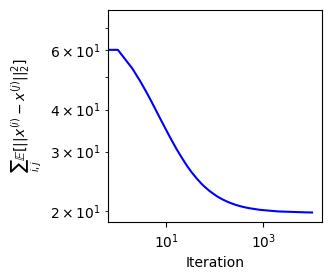

In [30]:
fig, ax = plt.subplots();
ax.plot(np.array(dists_coll_xy), color="blue")
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel('Iteration')
ax.set_ylabel(r'$\sum_{i,j} \mathbb{E}[||x^{(i)}-x^{(j)}||_2^2]$')
fig.set_size_inches(size*cm, size*cm)
fig.savefig('evol_cost_5marginal.pdf',format='pdf', bbox_inches="tight", dpi=300)

In [12]:
import torch
from torch import nn

class Model(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=100, out_marg=4):
        super(Model, self).__init__()
        self.out_marg = out_marg
        self.input_dim = input_dim
        
        self.fc0 = nn.Sequential(
            nn.Linear(input_dim, input_dim*out_marg)
        )
            
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim*out_marg)
        )

    def forward(self, x):
        # x:  (Np, dim)
        x = self.fc(x) # (Np, input_dim*out_marg)

        x = x.view(x.shape[0], self.out_marg, self.input_dim)
        
        x = x.permute(1, 0, 2)
        
        # output x: out_marg, Np, input_dim
        return x
    
    def loss(self, X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
        loss = torch.mean(torch.sum((self.forward(X) - Y) ** 2, dim=2))
        return loss

Epoch 1000, Loss: 0.02017635852098465
Epoch 2000, Loss: 0.01457582414150238
Epoch 3000, Loss: 0.013084378093481064
Epoch 4000, Loss: 0.01233886182308197
Epoch 5000, Loss: 0.011910686269402504
Epoch 6000, Loss: 0.011519509367644787
Epoch 7000, Loss: 0.011198894120752811
Epoch 8000, Loss: 0.010974274016916752
Epoch 9000, Loss: 0.01091011893004179
Epoch 10000, Loss: 0.010619815438985825


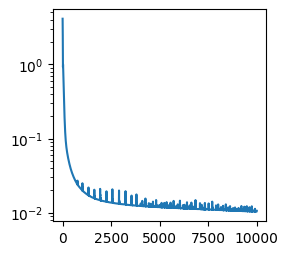

In [22]:
from torch import nn, optim

Xtr = torch.tensor(X[0,:,:], dtype=torch.float32)
Ytr = torch.tensor(X[1:,:,:], dtype=torch.float32)

# Create a simple model and optimizer
model_coll = Model(input_dim=2)
optimizer = optim.Adam(model_coll.parameters(), lr=1e-3)

# Training loop
n_epochs = 10000
losses = []

for epoch in range(1, n_epochs+1):
      optimizer.zero_grad()
      loss = model_coll.loss(Xtr, Ytr)
      loss.backward()
      optimizer.step()
      if epoch % 1000 == 0:
          print(f"Epoch {epoch}, Loss: {loss.item()}")
      losses.append(loss.item())

model_coll.eval()

fig, ax = plt.subplots();
ax.plot(losses)
ax.set_yscale("log")
fig.set_size_inches(size*cm, size*cm)


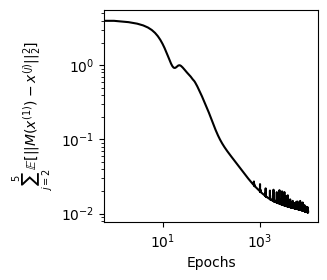

In [32]:
fig, ax = plt.subplots();
ax.plot(losses, color="black")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('Epochs')
ax.set_ylabel(r'$\sum_{j=2}^5 \mathbb{E}[||M(x^{(1)})-x^{(j)}||_2^2]$')

fig.set_size_inches(size*cm, size*cm)
fig.savefig('train_map_1-to-4marginal.pdf',format='pdf', bbox_inches="tight", dpi=300)

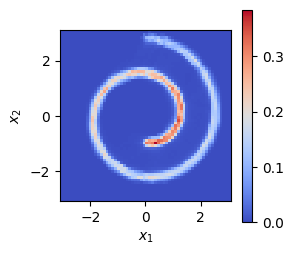

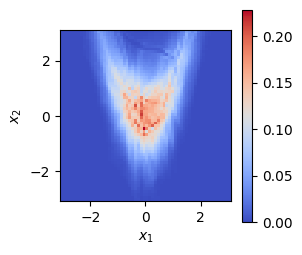

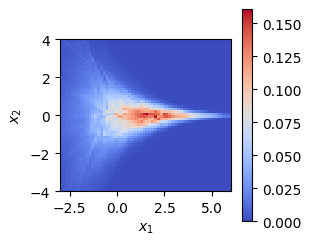

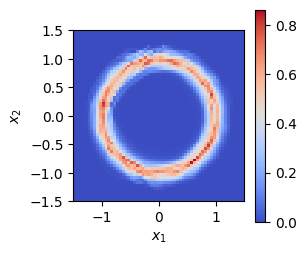

In [26]:
def plot_2d_density_single(x, xp=None, bins=60, range=[[-1.5,1.5],[-1.5,1.5]]):
    if xp is None:
        xp = x
    fig = plt.figure()
    # Create the second subplot of Y
    ax = plt.subplot()
    hist = plt.hist2d(x[:,0 ], x[:, 1], bins=bins, density=True, cmap='coolwarm', range=range)
    plt.colorbar()
    ax.set_aspect('equal', adjustable='box')  # Ensure aspect ratio is 1
    return fig, ax


Xtest = np.random.normal(0,1,(5*10**6,2))
Xtest = torch.tensor(Xtest, dtype=torch.float32)
Ytest = model_coll.forward(Xtest)

Ytest_np = Ytest.detach().numpy()

# first output marginal
iNm = 0
fig, ax = plot_2d_density_single(Ytest_np[iNm,:,:], xp=Ytest_np[iNm,:,:], bins=60, range=[[-3.1,3.1],[-3.1,3.1]])
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
fig.set_size_inches(size*cm, size*cm)
fig.savefig('swiss_roll_coll.pdf',format='pdf', bbox_inches="tight", dpi=300)

# second marginal
iNm = 1
fig, ax = plot_2d_density_single(Ytest_np[iNm,:,:], xp=Ytest_np[iNm,:,:], bins=60, range=[[-3.1,3.1],[-3.1,3.1]])
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
fig.set_size_inches(size*cm, size*cm)
fig.savefig('banana_coll.pdf',format='pdf', bbox_inches="tight", dpi=300)


# third marginal
iNm = 2
fig, ax = plot_2d_density_single(Ytest_np[iNm,:,:], xp=Ytest_np[iNm,:,:], bins=60, range=[[-3,6],[-4,4]])
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
fig.set_size_inches(size*cm, size*cm)
fig.savefig('funnel_coll.pdf',format='pdf', bbox_inches="tight", dpi=300)

# fourth marginal
iNm = 3
fig, ax = plot_2d_density_single(Ytest_np[iNm,:,:], xp=Ytest_np[iNm,:,:], bins=60, range=[[-1.5,1.5],[-1.5,1.5]])
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
fig.set_size_inches(size*cm, size*cm)
fig.savefig('ring_coll.pdf',format='pdf', bbox_inches="tight", dpi=300)

plt.show()

### Compare each normal to target with EMD, Sinkhorn

#### Normal and Swiss Roll

In [111]:
import time
from lib.collision_wrapper import find_OT_collision as newot
import tracemalloc
tracemalloc.start()

navg = 10
dim = 2
Nps = [1000, 2000, 4000, 8000, 16000]

errors_xy = []
mem_emd  = []
mem_sinkhorn  = []
mem_sinkhorn2  = []
mem_coll = []
mem_isa = []
ex_time_emd  = []
ex_time_sinkhorn  = []
ex_time_sinkhorn2  = []
ex_time_coll = []
ex_time_isa = []
iter_coll_xy = []
hist_coll_w = [[] for i in range(len(Nps))]
err_hist_coll_w = [[] for i in range(len(Nps))]
iter_isa_xy = []
hist_isa_w = [[] for i in range(len(Nps))]
err_hist_isa_w = [[] for i in range(len(Nps))]

k=0
for Np in Nps:
  print("Np:", Np)
  k = k + 1

  emd_t = 0
  sinkhorn_t = 0
  sinkhorn2_t = 0
  coll_t = 0
  isa_t = 0
  emd_avgmem = 0.0
  sinkhorn_avgmem = 0.0
  sinkhorn2_avgmem = 0.0
  coll_avgmem = 0.0
  isa_avgmem = 0.0
  for av in range(navg):
      x00 = np.random.normal(0,1,(Np,dim))
      #swiss roll
      y00 = swissroll(Np)
    
      ## compute EMD
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_emd = x00.copy(); y_emd = y00.copy();
      start_time = time.time()
      x_emd, y_emd = find_optimal_map_nd(x_emd, y_emd)
      first_size, second_peak = tracemalloc.get_traced_memory()
      emd_avgmem += second_peak - first_peak
      emd_t += time.time() - start_time
      #print("EMD Done")
      w_emd_xy = np.mean(np.sum((x_emd-y_emd)**2, axis=1))
      del x_emd, y_emd

      ## compute Sinkhorn
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
      start_time = time.time()
      x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=1)
      first_size, second_peak = tracemalloc.get_traced_memory()
      sinkhorn_avgmem += second_peak - first_peak
      sinkhorn_t += time.time() - start_time
      #print("Sinkhorn Done")
      del x_sinkhorn, y_sinkhorn
    
      ## compute Sinkhorn
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
      start_time = time.time()
      x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=0.5)
      first_size, second_peak = tracemalloc.get_traced_memory()
      sinkhorn2_avgmem += second_peak - first_peak
      sinkhorn2_t += time.time() - start_time
      #print("Sinkhorn2 Done")
      del x_sinkhorn, y_sinkhorn

      ## compute collision based
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      start_time = time.time()
      X=np.zeros((2,x00.shape[0],x00.shape[1]))
      X[0,:,:] = x00.copy()
      X[1,:,:] = y00.copy()
      X, dists_coll_xy, nt = newot(X, MinIter=1000, MaxIter=1000, tol = 1e-9, avg_window=20, Track=1)
      first_size, second_peak = tracemalloc.get_traced_memory()
      coll_avgmem += second_peak - first_peak
      coll_t += time.time() - start_time
      hist_coll_w[k-1].append(np.array( (dists_coll_xy)) )
      err_hist_coll_w[k-1].append( abs( np.array( (dists_coll_xy)) - w_emd_xy) )
      #print("coll Done")
      del X

      ## compute ISA
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      start_time = time.time()
      X=np.zeros((2,x00.shape[0],x00.shape[1]))
      X[0,:,:] = x00.copy()
      X[1,:,:] = y00.copy()
      X, dists_isa_xy, nt = ISA(X, MinIter=5, MaxIter=5, tol = 1e-3, avg_window=1, Track=1)
      first_size, second_peak = tracemalloc.get_traced_memory()
      isa_avgmem += second_peak - first_peak
      isa_t += time.time() - start_time
      hist_isa_w[k-1].append(np.array( (dists_isa_xy)) )
      err_hist_isa_w[k-1].append( abs( np.array( (dists_isa_xy)) - w_emd_xy) )
      #print("coll Done")
      del X

  mem_emd.append(emd_avgmem/navg)
  mem_coll.append(coll_avgmem/navg)
  mem_isa.append(isa_avgmem/navg)
  mem_sinkhorn.append(sinkhorn_avgmem/navg)
  mem_sinkhorn2.append(sinkhorn2_avgmem/navg)
  ex_time_emd.append(emd_t/navg)
  ex_time_coll.append(coll_t/navg)
  ex_time_isa.append(isa_t/navg)
  ex_time_sinkhorn.append(sinkhorn_t/navg)
  ex_time_sinkhorn2.append(sinkhorn2_t/navg)

Np: 1000
Np: 2000
Np: 4000
Np: 8000
Np: 16000


In [83]:
err_hist_coll_w

[[array([5.03870997e+00, 3.06333376e+00, 2.24627649e+00, ...,
         3.74195113e-03, 3.74195113e-03, 3.73999175e-03])],
 [array([5.08609597, 3.01215438, 2.18738439, ..., 0.00686176, 0.00685375,
         0.00684922])]]

5.140226507347091 -0.4013332137416909


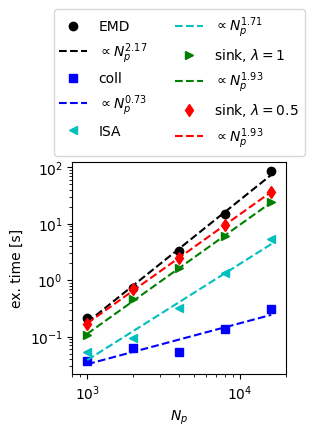

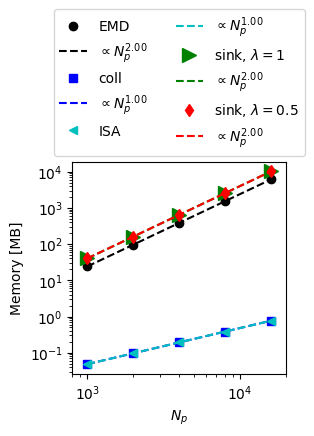

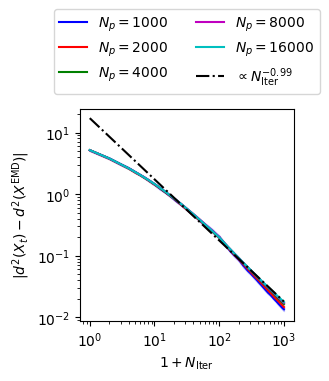

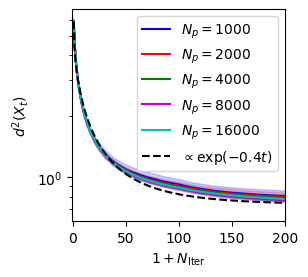

In [112]:
from scipy.stats import linregress
from scipy.optimize import curve_fit

def fit_exp(x, y):
    log_x = np.log10(x)
    log_y = np.log10(y)

    slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
    slope_str = f'{slope:.2f}'

    fitted_y = 10**(intercept + slope * log_x)
    return slope, slope_str, fitted_y

###############################################

fig, ax = plt.subplots();

ax.plot(Nps, ex_time_emd, color="black", marker="o", label="EMD", linewidth=0)
slope_emd, slope_emd_str, ex_time_emd_fit_y = fit_xp(Nps, ex_time_emd)
ax.plot(Nps, ex_time_emd_fit_y, label=r'$\propto N_p^{'+slope_emd_str+'}$', color='black', linestyle="--")

ax.plot(Nps, ex_time_coll, color="blue", marker="s", label="coll", linewidth=0)
slope_coll, slope_coll_str, ex_time_coll_fit_y = fit_xp(Nps, ex_time_coll)
ax.plot(Nps, ex_time_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(Nps, ex_time_isa, color="c", marker="<", label="ISA", linewidth=0)
slope_isa, slope_isa_str, ex_time_isa_fit_y = fit_xp(Nps, ex_time_isa)
ax.plot(Nps, ex_time_isa_fit_y, label=r'$\propto N_p^{'+slope_isa_str+'}$', color='c', linestyle="--")

ax.plot(Nps, ex_time_sinkhorn, color="green", marker=">", label=r"sink, $\lambda=1$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, ex_time_sinkhorn_fit_y = fit_xp(Nps, ex_time_sinkhorn)
ax.plot(Nps, ex_time_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='green', linestyle="--")

ax.plot(Nps, ex_time_sinkhorn2, color="red", marker="d", label=r"sink, $\lambda=0.5$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, ex_time_sinkhorn_fit_y = fit_xp(Nps, ex_time_sinkhorn2)
ax.plot(Nps, ex_time_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks([1000,10000],[r'$10^3$',r'$10^4$'])
ax.set_xlim([800,20000])
ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"ex. time [s]")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.75), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('SwissNormal_ex_time_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

###############################################
fig, ax = plt.subplots();

ax.plot(Nps, np.array(mem_emd)/1e6, color="black", marker="o", label="EMD", linewidth=0)
slope_emd, slope_emd_str, mem_emd_fit_y = fit_xp(Nps, np.array(mem_emd)/1e6)
ax.plot(Nps, mem_emd_fit_y, label=r'$\propto N_p^{'+slope_emd_str+'}$', color='black', linestyle="--")

ax.plot(Nps, np.array(mem_coll)/1e6, color="blue", marker="s", label="coll", linewidth=0)
slope_coll, slope_coll_str, mem_coll_fit_y = fit_xp(Nps, np.array(mem_coll)/1e6)
ax.plot(Nps, mem_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(Nps, np.array(mem_isa)/1e6, color="c", marker="<", label="ISA", linewidth=0)
slope_isa, slope_isa_str, mem_isa_fit_y = fit_xp(Nps, np.array(mem_isa)/1e6)
ax.plot(Nps, mem_isa_fit_y, label=r'$\propto N_p^{'+slope_isa_str+'}$', color='c', linestyle="--")

ax.plot(Nps, np.array(mem_sinkhorn)/1e6, color="green", marker=">", label=r"sink, $\lambda=1$", linewidth=0, markersize=10)
slope_sinkhorn, slope_sinkhorn_str, mem_sinkhorn_fit_y = fit_xp(Nps, np.array(mem_sinkhorn)/1e6)
ax.plot(Nps, mem_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='green', linestyle="--")

ax.plot(Nps, np.array(mem_sinkhorn2)/1e6, color="red", marker="d", label=r"sink, $\lambda=0.5$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, mem_sinkhorn_fit_y = fit_xp(Nps, np.array(mem_sinkhorn2)/1e6)
ax.plot(Nps, mem_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xticks([1000,10000],[r'$10^3$',r'$10^4$'])
ax.set_xlim([800,20000])

ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"Memory [MB]")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.75), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('SwissNormal_mem_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

################################
fig, ax = plt.subplots();
for k in range(len(Nps)):
    nmin = 10000000
    for jj in range(len(err_hist_coll_w[k])):
      if len(err_hist_coll_w[k][jj]) < nmin:
        nmin = len(err_hist_coll_w[k][jj])-1
    err_hist_coll_w_k = np.zeros( (len(err_hist_coll_w[k]), nmin) )
    for jj in range(len(hist_coll_w[k])):
      for ii in range(nmin):
        err_hist_coll_w_k[jj,ii] = err_hist_coll_w[k][jj][ii]
    xx = [i+1 for i in range(nmin)]
    mean_err = np.mean(err_hist_coll_w_k, axis=0)
    std_err = np.var(err_hist_coll_w_k,axis=0)**0.5
    ax.plot(xx, mean_err, color=cls[k], markevery=100, label=r"$N_p="+str(Nps[k])+"$")
    ax.fill_between(xx, mean_err-std_err, mean_err+std_err, color=cls[k], alpha=0.2)
    #for av in range(navg):
    #    ax.plot(hist_coll_w[k][av], color=cls[k], marker=markers[av], markevery=100, label=r"$N_p="+str(Nps[k])+"\ rep.\ "+str(av+1)+"$")

t = np.array([i+1 for i in range(len(mean_err))])
slope, slope_str, fitted_y = fit_exp(t, mean_err)
ax.plot(t, fitted_y, color="black", linestyle="-.", label=r"$\propto N_\mathrm{Iter}^{"+slope_str+"}$")

ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_ylabel(r"$| d^2_\mathrm{coll}({x}^{(1)},{x}^{(2)}) - d^2_\mathrm{EMD}({x}^{(1)},{x}^{(2)})|$")
ax.set_ylabel(r"$|d^2(X_t)-d^2(X^\mathrm{EMD})|$")
ax.set_xlabel(r"$1+N_\mathrm{Iter}$")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('SwissNormal_evol_rel_error_EMD_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

###############################################
fig, ax = plt.subplots();

for k in range(len(Nps)):
    nmin = 10000000
    for jj in range(len(err_hist_coll_w[k])):
      if len(err_hist_coll_w[k][jj]) < nmin:
        nmin = len(hist_coll_w[k][jj])-1
    hist_coll_w_k = np.zeros( (len(hist_coll_w[k]), nmin) )
    for jj in range(len(hist_coll_w[k])):
      for ii in range(nmin):
        hist_coll_w_k[jj,ii] = hist_coll_w[k][jj][ii]
    xx = [i+1 for i in range(nmin)]
    mean = np.mean(hist_coll_w_k, axis=0)
    std = np.var(hist_coll_w_k,axis=0)**0.5
    ax.plot(xx, mean, color=cls[k], markevery=100, label=r"$N_p="+str(Nps[k])+"$")
    plt.fill_between(xx, mean-std, mean+std, color=cls[k], alpha=0.2)
    
def exponential_function(x, a, b):
    return a*(np.exp(b*(x-1)**0.5)-1.) + mean[0]

y = np.array(mean)
x = np.array([i+1 for i in range(len(y))])
initial_guess = [1, -0.1]  # Initial guess for the parameters a and b
params, covariance = curve_fit(exponential_function, x, y, p0=initial_guess)
a_fitted, b_fitted = params
print(a_fitted, b_fitted)
y_fitted = exponential_function(x, a_fitted, b_fitted)
ax.plot(x, y_fitted, color="black", label="$\propto \exp("+str(round(b_fitted,2))+r"t)$", linestyle="--")
ax.set_xlim([-1,200])

#ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel(r"$d^2(X_t)$")
ax.set_xlabel(r"$1+N_\mathrm{Iter}$")
ax.legend()#loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('SwissNormal_evol_W2_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);


#### Normal and Banana

In [90]:
import time
from lib.collision_wrapper import find_OT_collision as newot
import tracemalloc
tracemalloc.start()

rng = np.random.seed(1)
navg = 2
dim = 2
Nps = [1000, 2000, 4000, 8000 , 16000]

errors_xy = []
mem_emd  = []
mem_sinkhorn  = []
mem_sinkhorn2  = []
mem_coll = []
ex_time_emd  = []
ex_time_sinkhorn  = []
ex_time_sinkhorn2  = []
ex_time_coll = []
iter_coll_xy = []
hist_coll_w = [[] for i in range(len(Nps))]
err_hist_coll_w = [[] for i in range(len(Nps))]

k=0
for Np in Nps:
  print("Np:", Np)
  
  k = k + 1

  emd_t = 0
  sinkhorn_t = 0
  sinkhorn2_t = 0
  coll_t = 0
  errors_xy_ = 0
  errors_yz_ = 0
  errors_xz_ = 0
  nt_xy_ = 0
  nt_yz_ = 0
  emd_avgmem = 0.0
  sinkhorn_avgmem = 0.0
  sinkhorn2_avgmem = 0.0
  coll_avgmem = 0.0
  for av in range(navg):
      x00 = np.random.normal(0,1,(Np,dim))
      #banana
      y00 = sample_banana(Np)
    
      ## compute EMD
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_emd = x00.copy(); y_emd = y00.copy();
      start_time = time.time()
      x_emd, y_emd = find_optimal_map_nd(x_emd, y_emd)
      first_size, second_peak = tracemalloc.get_traced_memory()
      emd_avgmem += second_peak - first_peak
      emd_t += time.time() - start_time
      print("EMD Done")
      w_emd_xy = np.mean(np.sum((x_emd-y_emd)**2, axis=1))
      del x_emd, y_emd

      ## compute Sinkhorn
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
      start_time = time.time()
      x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=1)
      first_size, second_peak = tracemalloc.get_traced_memory()
      sinkhorn_avgmem += second_peak - first_peak
      sinkhorn_t += time.time() - start_time
      print("Sinkhorn Done")
      del x_sinkhorn, y_sinkhorn
    
      ## compute Sinkhorn
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
      start_time = time.time()
      x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=0.5)
      first_size, second_peak = tracemalloc.get_traced_memory()
      sinkhorn2_avgmem += second_peak - first_peak
      sinkhorn2_t += time.time() - start_time
      print("Sinkhorn2 Done")
      del x_sinkhorn, y_sinkhorn

      ## compute collision based
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_coll = x00.copy(); y_coll = y00.copy();
      start_time = time.time()
      X=np.zeros((2,x00.shape[0],x00.shape[1]))
      X[0,:,:] = x00.copy()
      X[1,:,:] = y00.copy()
      X, dists_coll_xy = newot(X, MinIter=1000, MaxIter=1000, tol = 1e-9, avg_window=20, Track=1)
      first_size, second_peak = tracemalloc.get_traced_memory()
      coll_avgmem += second_peak - first_peak
      coll_t += time.time() - start_time
      
      x_coll = X[0,:,:]
      y_coll = X[1,:,:]
      hist_coll_w[k-1].append(np.array( (dists_coll_xy)) )
      err_hist_coll_w[k-1].append( abs( np.array( (dists_coll_xy)) - w_emd_xy) )
      print("coll Done")
      del x_coll, y_coll

  iter_coll_xy.append(nt_xy_/navg)

  mem_emd.append(emd_avgmem/navg)
  mem_coll.append(coll_avgmem/navg)
  mem_sinkhorn.append(sinkhorn_avgmem/navg)
  mem_sinkhorn2.append(sinkhorn2_avgmem/navg)
  ex_time_emd.append(emd_t/navg)
  ex_time_coll.append(coll_t/navg)
  ex_time_sinkhorn.append(sinkhorn_t/navg)
  ex_time_sinkhorn2.append(sinkhorn2_t/navg)
  errors_xy.append( errors_xy_/navg )

Np: 1000
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
Np: 2000
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
Np: 4000
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
Np: 8000
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
Np: 16000
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done


5.008863760985599 -0.5150947694492882


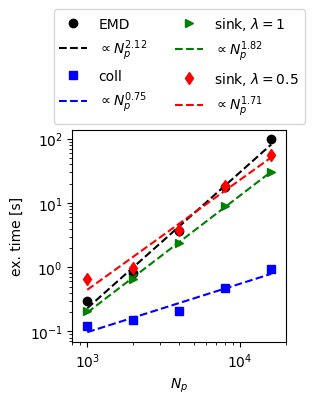

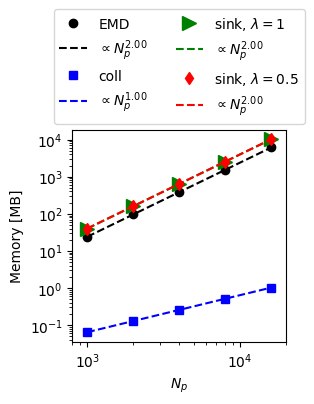

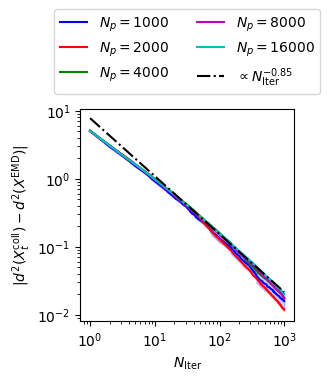

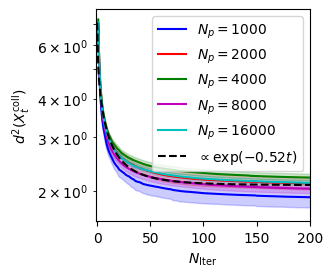

In [91]:
from scipy.stats import linregress
def fit_exp(x, y):
    log_x = np.log10(x)
    log_y = np.log10(y)

    slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
    slope_str = f'{slope:.2f}'

    fitted_y = 10**(intercept + slope * log_x)
    return slope, slope_str, fitted_y

###############################################
fig, ax = plt.subplots();

ax.plot(Nps, ex_time_emd, color="black", marker="o", label="EMD", linewidth=0)
slope_emd, slope_emd_str, ex_time_emd_fit_y = fit_xp(Nps, ex_time_emd)
ax.plot(Nps, ex_time_emd_fit_y, label=r'$\propto N_p^{'+slope_emd_str+'}$', color='black', linestyle="--")

ax.plot(Nps, ex_time_coll, color="blue", marker="s", label="coll", linewidth=0)
slope_coll, slope_coll_str, ex_time_coll_fit_y = fit_xp(Nps, ex_time_coll)
ax.plot(Nps, ex_time_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(Nps, ex_time_sinkhorn, color="green", marker=">", label=r"sink, $\lambda=1$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, ex_time_sinkhorn_fit_y = fit_xp(Nps, ex_time_sinkhorn)
ax.plot(Nps, ex_time_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='green', linestyle="--")

ax.plot(Nps, ex_time_sinkhorn2, color="red", marker="d", label=r"sink, $\lambda=0.5$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, ex_time_sinkhorn_fit_y = fit_xp(Nps, ex_time_sinkhorn2)
ax.plot(Nps, ex_time_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks([1000,10000],[r'$10^3$',r'$10^4$'])
ax.set_xlim([800,20000])
ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"ex. time [s]")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.6), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('BananaNormal_ex_time_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

###############################################
fig, ax = plt.subplots();

ax.plot(Nps, np.array(mem_emd)/1e6, color="black", marker="o", label="EMD", linewidth=0)
slope_emd, slope_emd_str, mem_emd_fit_y = fit_xp(Nps, np.array(mem_emd)/1e6)
ax.plot(Nps, mem_emd_fit_y, label=r'$\propto N_p^{'+slope_emd_str+'}$', color='black', linestyle="--")

ax.plot(Nps, np.array(mem_coll)/1e6, color="blue", marker="s", label="coll", linewidth=0)
slope_coll, slope_coll_str, mem_coll_fit_y = fit_xp(Nps, np.array(mem_coll)/1e6)
ax.plot(Nps, mem_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(Nps, np.array(mem_sinkhorn)/1e6, color="green", marker=">", label=r"sink, $\lambda=1$", linewidth=0, markersize=10)
slope_sinkhorn, slope_sinkhorn_str, mem_sinkhorn_fit_y = fit_xp(Nps, np.array(mem_sinkhorn)/1e6)
ax.plot(Nps, mem_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='green', linestyle="--")

ax.plot(Nps, np.array(mem_sinkhorn2)/1e6, color="red", marker="d", label=r"sink, $\lambda=0.5$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, mem_sinkhorn_fit_y = fit_xp(Nps, np.array(mem_sinkhorn2)/1e6)
ax.plot(Nps, mem_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xticks([1000,10000],[r'$10^3$',r'$10^4$'])
ax.set_xlim([800,20000])

ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"Memory [MB]")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.6), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('BananaNormal_mem_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

###############################################
fig, ax = plt.subplots();
for k in range(len(Nps)):
    nmin = 10000000
    for jj in range(len(err_hist_coll_w[k])):
      if len(err_hist_coll_w[k][jj]) < nmin:
        nmin = len(err_hist_coll_w[k][jj])-1
    err_hist_coll_w_k = np.zeros( (len(err_hist_coll_w[k]), nmin) )
    for jj in range(len(hist_coll_w[k])):
      for ii in range(nmin):
        err_hist_coll_w_k[jj,ii] = err_hist_coll_w[k][jj][ii]
    xx = [i+1 for i in range(nmin)]
    mean_err = np.mean(err_hist_coll_w_k, axis=0)
    std_err = np.var(err_hist_coll_w_k,axis=0)**0.5
    ax.plot(xx, mean_err, color=cls[k], markevery=100, label=r"$N_p="+str(Nps[k])+"$")
    plt.fill_between(xx, mean_err-std_err, mean_err+std_err, color=cls[k], alpha=0.2)
    #for av in range(navg):
    #    ax.plot(hist_coll_w[k][av], color=cls[k], marker=markers[av], markevery=100, label=r"$N_p="+str(Nps[k])+"\ rep.\ "+str(av+1)+"$")

t = np.array([i+1 for i in range(len(mean_err))])
slope, slope_str, fitted_y = fit_exp(t, mean_err)
ax.plot(t, fitted_y, color="black", linestyle="-.", label=r"$\propto N_\mathrm{Iter}^{"+slope_str+"}$")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$|d^2(X_t^\mathrm{coll})-d^2(X^\mathrm{EMD})|$")
ax.set_xlabel(r"$N_\mathrm{Iter}$")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('BananaNormal_evol_rel_error_EMD_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

###############################################
fig, ax = plt.subplots();

for k in range(len(Nps)):
    nmin = 10000000
    for jj in range(len(err_hist_coll_w[k])):
      if len(err_hist_coll_w[k][jj]) < nmin:
        nmin = len(hist_coll_w[k][jj])-1
    hist_coll_w_k = np.zeros( (len(hist_coll_w[k]), nmin) )
    for jj in range(len(hist_coll_w[k])):
      for ii in range(nmin):
        hist_coll_w_k[jj,ii] = hist_coll_w[k][jj][ii]
    xx = [i+1 for i in range(nmin)]
    mean = np.mean(hist_coll_w_k, axis=0)
    std = np.var(hist_coll_w_k,axis=0)**0.5
    ax.plot(xx, mean, color=cls[k], markevery=100, label=r"$N_p="+str(Nps[k])+"$")
    plt.fill_between(xx, mean-std, mean+std, color=cls[k], alpha=0.2)
    
def exponential_function(x, a, b):
    return a*(np.exp(b*x**0.5)-1.) + mean[0]

y = np.array(mean)
x = np.array([i for i in range(len(y))])
initial_guess = [1, -0.1]  # Initial guess for the parameters a and b
params, covariance = curve_fit(exponential_function, x, y, p0=initial_guess)
a_fitted, b_fitted = params
print(a_fitted, b_fitted)
y_fitted = exponential_function(x, a_fitted, b_fitted)
ax.plot(x, y_fitted, color="black", label="$\propto \exp("+str(round(b_fitted,2))+r"t)$", linestyle="--")
ax.set_xlim([-1,200])

#ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel(r"$d^2(X_t^\mathrm{coll})$")
ax.set_xlabel(r"$N_\mathrm{Iter}$")
ax.legend()#loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('BananaNormal_evol_W2_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

#### Normal and Funnel

In [92]:
import time
from lib.collision_wrapper import find_OT_collision as newot
import tracemalloc
tracemalloc.start()

navg = 2
dim = 2
Nps = [1000, 2000, 4000, 8000 , 16000]

errors_xy = []
mem_emd  = []
mem_sinkhorn  = []
mem_sinkhorn2  = []
mem_coll = []
ex_time_emd  = []
ex_time_sinkhorn  = []
ex_time_sinkhorn2  = []
ex_time_coll = []
iter_coll_xy = []
hist_coll_w = [[] for i in range(len(Nps))]
err_hist_coll_w = [[] for i in range(len(Nps))]

funnel = Funnel(d=2,sigma=2)
k=0
for Np in Nps:
  print("Np:", Np)
  
  k = k + 1

  emd_t = 0
  sinkhorn_t = 0
  sinkhorn2_t = 0
  coll_t = 0
  errors_xy_ = 0
  errors_yz_ = 0
  errors_xz_ = 0
  nt_xy_ = 0
  nt_yz_ = 0
  emd_avgmem = 0.0
  sinkhorn_avgmem = 0.0
  sinkhorn2_avgmem = 0.0
  coll_avgmem = 0.0
  for av in range(navg):
      x00 = np.random.normal(0,1,(Np,dim))
      y00 = funnel.sample(Np)
    
      ## compute EMD
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_emd = x00.copy(); y_emd = y00.copy();
      start_time = time.time()
      x_emd, y_emd = find_optimal_map_nd(x_emd, y_emd)
      first_size, second_peak = tracemalloc.get_traced_memory()
      emd_avgmem += second_peak - first_peak
      emd_t += time.time() - start_time
      print("EMD Done")
      w_emd_xy = np.mean(np.sum((x_emd-y_emd)**2, axis=1))
      del x_emd, y_emd

      ## compute Sinkhorn
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
      start_time = time.time()
      x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=1)
      first_size, second_peak = tracemalloc.get_traced_memory()
      sinkhorn_avgmem += second_peak - first_peak
      sinkhorn_t += time.time() - start_time
      print("Sinkhorn Done")
      del x_sinkhorn, y_sinkhorn
    
      ## compute Sinkhorn
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
      start_time = time.time()
      x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=0.5)
      first_size, second_peak = tracemalloc.get_traced_memory()
      sinkhorn2_avgmem += second_peak - first_peak
      sinkhorn2_t += time.time() - start_time
      print("Sinkhorn2 Done")
      del x_sinkhorn, y_sinkhorn

      ## compute collision based
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_coll = x00.copy(); y_coll = y00.copy();
      start_time = time.time()
      X=np.zeros((2,x00.shape[0],x00.shape[1]))
      X[0,:,:] = x00.copy()
      X[1,:,:] = y00.copy()
      X, dists_coll_xy = newot(X, MinIter=1000, MaxIter=1000, tol = 1e-9, avg_window=20, Track=1)
      first_size, second_peak = tracemalloc.get_traced_memory()
      coll_avgmem += second_peak - first_peak
      coll_t += time.time() - start_time
      
      x_coll = X[0,:,:]
      y_coll = X[1,:,:]
      hist_coll_w[k-1].append(np.array( (dists_coll_xy)) )
      err_hist_coll_w[k-1].append( abs( np.array( (dists_coll_xy)) - w_emd_xy) )
      print("coll Done")
      del x_coll, y_coll

  iter_coll_xy.append(nt_xy_/navg)

  mem_emd.append(emd_avgmem/navg)
  mem_coll.append(coll_avgmem/navg)
  mem_sinkhorn.append(sinkhorn_avgmem/navg)
  mem_sinkhorn2.append(sinkhorn2_avgmem/navg)
  ex_time_emd.append(emd_t/navg)
  ex_time_coll.append(coll_t/navg)
  ex_time_sinkhorn.append(sinkhorn_t/navg)
  ex_time_sinkhorn2.append(sinkhorn2_t/navg)
  errors_xy.append( errors_xy_/navg )

Np: 1000
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
Np: 2000
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
Np: 4000
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
Np: 8000
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
Np: 16000
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done


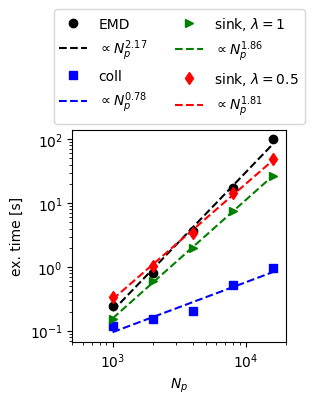

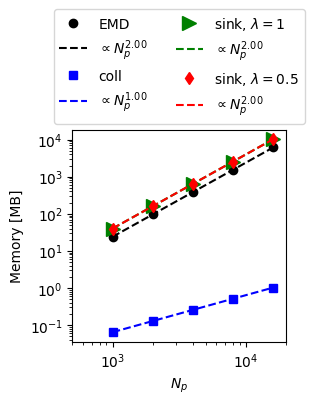

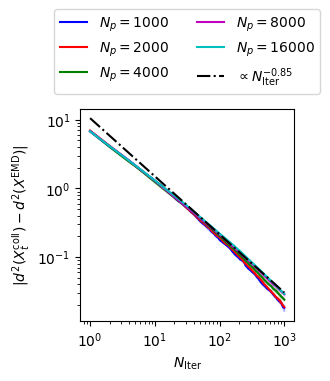

In [93]:
from scipy.stats import linregress
def fit_exp(x, y):
    log_x = np.log10(x)
    log_y = np.log10(y)

    slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
    slope_str = f'{slope:.2f}'

    fitted_y = 10**(intercept + slope * log_x)
    return slope, slope_str, fitted_y

###############################################
fig, ax = plt.subplots();

ax.plot(Nps, ex_time_emd, color="black", marker="o", label="EMD", linewidth=0)
slope_emd, slope_emd_str, ex_time_emd_fit_y = fit_xp(Nps, ex_time_emd)
ax.plot(Nps, ex_time_emd_fit_y, label=r'$\propto N_p^{'+slope_emd_str+'}$', color='black', linestyle="--")

ax.plot(Nps, ex_time_coll, color="blue", marker="s", label="coll", linewidth=0)
slope_coll, slope_coll_str, ex_time_coll_fit_y = fit_xp(Nps, ex_time_coll)
ax.plot(Nps, ex_time_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(Nps, ex_time_sinkhorn, color="green", marker=">", label=r"sink, $\lambda=1$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, ex_time_sinkhorn_fit_y = fit_xp(Nps, ex_time_sinkhorn)
ax.plot(Nps, ex_time_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='green', linestyle="--")

ax.plot(Nps, ex_time_sinkhorn2, color="red", marker="d", label=r"sink, $\lambda=0.5$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, ex_time_sinkhorn_fit_y = fit_xp(Nps, ex_time_sinkhorn2)
ax.plot(Nps, ex_time_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks([1000,10000],[r'$10^3$',r'$10^4$'])
ax.set_xlim([500,20000])
ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"ex. time [s]")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.6), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('FunnelNormal_ex_time_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

###############################################
fig, ax = plt.subplots();

ax.plot(Nps, np.array(mem_emd)/1e6, color="black", marker="o", label="EMD", linewidth=0)
slope_emd, slope_emd_str, mem_emd_fit_y = fit_xp(Nps, np.array(mem_emd)/1e6)
ax.plot(Nps, mem_emd_fit_y, label=r'$\propto N_p^{'+slope_emd_str+'}$', color='black', linestyle="--")

ax.plot(Nps, np.array(mem_coll)/1e6, color="blue", marker="s", label="coll", linewidth=0)
slope_coll, slope_coll_str, mem_coll_fit_y = fit_xp(Nps, np.array(mem_coll)/1e6)
ax.plot(Nps, mem_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(Nps, np.array(mem_sinkhorn)/1e6, color="green", marker=">", label=r"sink, $\lambda=1$", linewidth=0, markersize=10)
slope_sinkhorn, slope_sinkhorn_str, mem_sinkhorn_fit_y = fit_xp(Nps, np.array(mem_sinkhorn)/1e6)
ax.plot(Nps, mem_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='green', linestyle="--")

ax.plot(Nps, np.array(mem_sinkhorn2)/1e6, color="red", marker="d", label=r"sink, $\lambda=0.5$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, mem_sinkhorn_fit_y = fit_xp(Nps, np.array(mem_sinkhorn2)/1e6)
ax.plot(Nps, mem_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xticks([1000,10000],[r'$10^3$',r'$10^4$'])
ax.set_xlim([500,20000])

ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"Memory [MB]")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.6), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('FunnelNormal_mem_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

###############################################
fig, ax = plt.subplots();
for k in range(len(Nps)):
    nmin = 10000000
    for jj in range(len(err_hist_coll_w[k])):
      if len(err_hist_coll_w[k][jj]) < nmin:
        nmin = len(err_hist_coll_w[k][jj])-1
    err_hist_coll_w_k = np.zeros( (len(err_hist_coll_w[k]), nmin) )
    for jj in range(len(hist_coll_w[k])):
      for ii in range(nmin):
        err_hist_coll_w_k[jj,ii] = err_hist_coll_w[k][jj][ii]
    xx = [i+1 for i in range(nmin)]
    mean_err = np.mean(err_hist_coll_w_k, axis=0)
    std_err = np.var(err_hist_coll_w_k,axis=0)**0.5
    ax.plot(xx, mean_err, color=cls[k], markevery=100, label=r"$N_p="+str(Nps[k])+"$")
    plt.fill_between(xx, mean_err-std_err, mean_err+std_err, color=cls[k], alpha=0.2)
    #for av in range(navg):
    #    ax.plot(hist_coll_w[k][av], color=cls[k], marker=markers[av], markevery=100, label=r"$N_p="+str(Nps[k])+"\ rep.\ "+str(av+1)+"$")

t = np.array([i+1 for i in range(len(mean_err))])
slope, slope_str, fitted_y = fit_exp(t, mean_err)
ax.plot(t, fitted_y, color="black", linestyle="-.", label=r"$\propto N_\mathrm{Iter}^{"+slope_str+"}$")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$|d^2(X_t^\mathrm{coll})-d^2(X^\mathrm{EMD})|$")
ax.set_xlabel(r"$N_\mathrm{Iter}$")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('FunnelNormal_evol_rel_error_EMD_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

#### Normal and Ring

In [94]:
import time
from lib.collision_wrapper import find_OT_collision as newot
import tracemalloc
tracemalloc.start()

navg = 2
dim = 2
Nps = [1000, 2000, 4000, 8000 , 16000]

errors_xy = []
mem_emd  = []
mem_sinkhorn  = []
mem_sinkhorn2  = []
mem_coll = []
ex_time_emd  = []
ex_time_sinkhorn  = []
ex_time_sinkhorn2  = []
ex_time_coll = []
iter_coll_xy = []
hist_coll_w = [[] for i in range(len(Nps))]
err_hist_coll_w = [[] for i in range(len(Nps))]

ring = Ring(d=2,sigma=0.1, radia=1.0)
k=0
for Np in Nps:
  print("Np:", Np)
  
  k = k + 1

  emd_t = 0
  sinkhorn_t = 0
  sinkhorn2_t = 0
  coll_t = 0
  errors_xy_ = 0
  errors_yz_ = 0
  errors_xz_ = 0
  nt_xy_ = 0
  nt_yz_ = 0
  emd_avgmem = 0.0
  sinkhorn_avgmem = 0.0
  sinkhorn2_avgmem = 0.0
  coll_avgmem = 0.0
  for av in range(navg):
      x00 = np.random.normal(0,1,(Np,dim))
      y00 = ring.sample(Np)
    
      ## compute EMD
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_emd = x00.copy(); y_emd = y00.copy();
      start_time = time.time()
      x_emd, y_emd = find_optimal_map_nd(x_emd, y_emd)
      first_size, second_peak = tracemalloc.get_traced_memory()
      emd_avgmem += second_peak - first_peak
      emd_t += time.time() - start_time
      print("EMD Done")
      w_emd_xy = np.mean(np.sum((x_emd-y_emd)**2, axis=1))
      del x_emd, y_emd

      ## compute Sinkhorn
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
      start_time = time.time()
      x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=1)
      first_size, second_peak = tracemalloc.get_traced_memory()
      sinkhorn_avgmem += second_peak - first_peak
      sinkhorn_t += time.time() - start_time
      print("Sinkhorn Done")
      del x_sinkhorn, y_sinkhorn
    
      ## compute Sinkhorn
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
      start_time = time.time()
      x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=0.5)
      first_size, second_peak = tracemalloc.get_traced_memory()
      sinkhorn2_avgmem += second_peak - first_peak
      sinkhorn2_t += time.time() - start_time
      print("Sinkhorn2 Done")
      del x_sinkhorn, y_sinkhorn

      ## compute collision based
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_coll = x00.copy(); y_coll = y00.copy();
      start_time = time.time()
      X=np.zeros((2,x00.shape[0],x00.shape[1]))
      X[0,:,:] = x00.copy()
      X[1,:,:] = y00.copy()
      X, dists_coll_xy = newot(X, MinIter=1000, MaxIter=1000, tol = 1e-9, avg_window=20, Track=1)
      first_size, second_peak = tracemalloc.get_traced_memory()
      coll_avgmem += second_peak - first_peak
      coll_t += time.time() - start_time
      
      x_coll = X[0,:,:]
      y_coll = X[1,:,:]
      hist_coll_w[k-1].append(np.array( (dists_coll_xy)) )
      err_hist_coll_w[k-1].append( abs( np.array( (dists_coll_xy)) - w_emd_xy) )
      print("coll Done")
      del x_coll, y_coll

  iter_coll_xy.append(nt_xy_/navg)

  mem_emd.append(emd_avgmem/navg)
  mem_coll.append(coll_avgmem/navg)
  mem_sinkhorn.append(sinkhorn_avgmem/navg)
  mem_sinkhorn2.append(sinkhorn2_avgmem/navg)
  ex_time_emd.append(emd_t/navg)
  ex_time_coll.append(coll_t/navg)
  ex_time_sinkhorn.append(sinkhorn_t/navg)
  ex_time_sinkhorn2.append(sinkhorn2_t/navg)
  errors_xy.append( errors_xy_/navg )

Np: 1000
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
Np: 2000
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
Np: 4000
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
Np: 8000
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
Np: 16000
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done


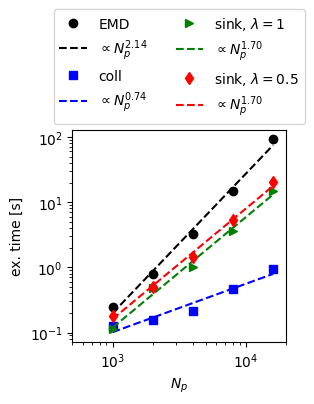

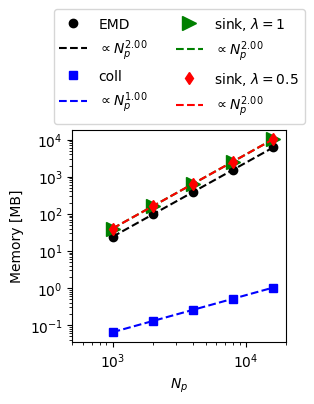

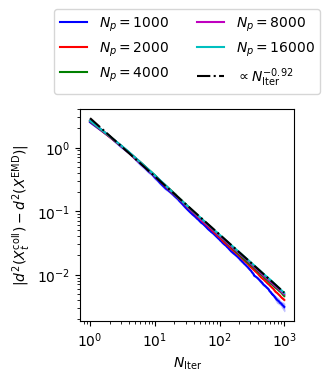

In [95]:
from scipy.stats import linregress
def fit_exp(x, y):
    log_x = np.log10(x)
    log_y = np.log10(y)

    slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
    slope_str = f'{slope:.2f}'

    fitted_y = 10**(intercept + slope * log_x)
    return slope, slope_str, fitted_y

###############################################
fig, ax = plt.subplots();

ax.plot(Nps, ex_time_emd, color="black", marker="o", label="EMD", linewidth=0)
slope_emd, slope_emd_str, ex_time_emd_fit_y = fit_xp(Nps, ex_time_emd)
ax.plot(Nps, ex_time_emd_fit_y, label=r'$\propto N_p^{'+slope_emd_str+'}$', color='black', linestyle="--")

ax.plot(Nps, ex_time_coll, color="blue", marker="s", label="coll", linewidth=0)
slope_coll, slope_coll_str, ex_time_coll_fit_y = fit_xp(Nps, ex_time_coll)
ax.plot(Nps, ex_time_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(Nps, ex_time_sinkhorn, color="green", marker=">", label=r"sink, $\lambda=1$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, ex_time_sinkhorn_fit_y = fit_xp(Nps, ex_time_sinkhorn)
ax.plot(Nps, ex_time_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='green', linestyle="--")

ax.plot(Nps, ex_time_sinkhorn2, color="red", marker="d", label=r"sink, $\lambda=0.5$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, ex_time_sinkhorn_fit_y = fit_xp(Nps, ex_time_sinkhorn2)
ax.plot(Nps, ex_time_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks([1000,10000],[r'$10^3$',r'$10^4$'])
ax.set_xlim([500,20000])
ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"ex. time [s]")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.6), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('RingNormal_ex_time_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

###############################################
fig, ax = plt.subplots();

ax.plot(Nps, np.array(mem_emd)/1e6, color="black", marker="o", label="EMD", linewidth=0)
slope_emd, slope_emd_str, mem_emd_fit_y = fit_xp(Nps, np.array(mem_emd)/1e6)
ax.plot(Nps, mem_emd_fit_y, label=r'$\propto N_p^{'+slope_emd_str+'}$', color='black', linestyle="--")

ax.plot(Nps, np.array(mem_coll)/1e6, color="blue", marker="s", label="coll", linewidth=0)
slope_coll, slope_coll_str, mem_coll_fit_y = fit_xp(Nps, np.array(mem_coll)/1e6)
ax.plot(Nps, mem_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(Nps, np.array(mem_sinkhorn)/1e6, color="green", marker=">", label=r"sink, $\lambda=1$", linewidth=0, markersize=10)
slope_sinkhorn, slope_sinkhorn_str, mem_sinkhorn_fit_y = fit_xp(Nps, np.array(mem_sinkhorn)/1e6)
ax.plot(Nps, mem_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='green', linestyle="--")

ax.plot(Nps, np.array(mem_sinkhorn2)/1e6, color="red", marker="d", label=r"sink, $\lambda=0.5$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, mem_sinkhorn_fit_y = fit_xp(Nps, np.array(mem_sinkhorn2)/1e6)
ax.plot(Nps, mem_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xticks([1000,10000],[r'$10^3$',r'$10^4$'])
ax.set_xlim([500,20000])

ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"Memory [MB]")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.6), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('RingNormal_mem_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

###############################################
fig, ax = plt.subplots();
for k in range(len(Nps)):
    nmin = 10000000
    for jj in range(len(err_hist_coll_w[k])):
      if len(err_hist_coll_w[k][jj]) < nmin:
        nmin = len(err_hist_coll_w[k][jj])-1
    err_hist_coll_w_k = np.zeros( (len(err_hist_coll_w[k]), nmin) )
    for jj in range(len(hist_coll_w[k])):
      for ii in range(nmin):
        err_hist_coll_w_k[jj,ii] = err_hist_coll_w[k][jj][ii]
    xx = [i+1 for i in range(nmin)]
    mean_err = np.mean(err_hist_coll_w_k, axis=0)
    std_err = np.var(err_hist_coll_w_k,axis=0)**0.5
    ax.plot(xx, mean_err, color=cls[k], markevery=100, label=r"$N_p="+str(Nps[k])+"$")
    plt.fill_between(xx, mean_err-std_err, mean_err+std_err, color=cls[k], alpha=0.2)
    #for av in range(navg):
    #    ax.plot(hist_coll_w[k][av], color=cls[k], marker=markers[av], markevery=100, label=r"$N_p="+str(Nps[k])+"\ rep.\ "+str(av+1)+"$")

t = np.array([i+1 for i in range(len(mean_err))])
slope, slope_str, fitted_y = fit_exp(t, mean_err)
ax.plot(t, fitted_y, color="black", linestyle="-.", label=r"$\propto N_\mathrm{Iter}^{"+slope_str+"}$")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$|d^2(X_t^\mathrm{coll})-d^2(X^\mathrm{EMD})|$")
ax.set_xlabel(r"$N_\mathrm{Iter}$")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('RingNormal_evol_rel_error_EMD_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

# Japanese Faces

In [10]:
import os
from PIL import Image
import numpy as np

import os

# Define the path to your dataset
dataset_path = './jaffedbase/'

# List the files to confirm they are accessible
files = os.listdir(dataset_path)
print(files)

data = []
# Process all images in the directory
for i in range(len(files)):
    image_name = files[i]
    if image_name.endswith('.tiff'):  # Ensure you only process .tiff files
        image_path = os.path.join(dataset_path, image_name)
        image = Image.open(image_path)
        data.append(image)

        # Convert the image to a numpy array
        image_array = np.array(image)

        # Example: Print the shape of each image
        print(f"Processed {image_name}: shape = {image_array.shape}")

['NM.FE1.110.tiff', 'KL.SU2.165.tiff', 'NA.SA2.206.tiff', 'NA.DI1.214.tiff', 'NA.AN3.213.tiff', 'KL.NE3.157.tiff', 'MK.HA3.118.tiff', 'NA.SU1.208.tiff', 'YM.NE3.51.tiff', 'TM.AN3.192.tiff', 'NA.SU2.209.tiff', 'YM.FE3.69.tiff', 'NA.FE2.218.tiff', 'UY.SA1.140.tiff', 'YM.HA3.54.tiff', 'NA.HA2.203.tiff', 'MK.FE3.133.tiff', 'NA.HA1.202.tiff', 'MK.SA3.121.tiff', 'YM.FE1.67.tiff', 'UY.NE3.136.tiff', 'KM.AN2.18.tiff', 'KA.SA3.35.tiff', 'KR.AN2.84.tiff', 'YM.NE1.49.tiff', 'KM.HA4.7.tiff', 'KM.FE3.25.tiff', 'NM.SA2.99.tiff', 'NA.NE2.200.tiff', 'UY.SA2.141.tiff', 'KA.DI1.42.tiff', 'KL.FE2.175.tiff', 'KL.NE1.155.tiff', 'NA.FE3.219.tiff', 'NA.AN2.212.tiff', 'KM.SU1.14.tiff', 'KL.SU3.166.tiff', 'KM.AN1.17.tiff', 'MK.NE1.113.tiff', '.DS_Store', 'TM.SU2.188.tiff', 'NA.DI2.215.tiff', 'KR.AN3.85.tiff', 'KA.HA2.30.tiff', 'KA.AN3.41.tiff', 'KL.DI2.171.tiff', 'KA.FE3.47.tiff', 'KA.FE4.48.tiff', 'YM.AN3.63.tiff', 'YM.DI1.64.tiff', 'NA.DI3.216.tiff', 'NM.HA2.96.tiff', 'KA.SU1.36.tiff', 'KR.FE1.89.tiff', 'YM.

In [11]:
data0 = np.array(data).copy()
data0 = data0[:,:,:]/256.
data0.shape

(213, 256, 256)

In [13]:
data = data0[:,::4,::4]
X = data.reshape((data.shape[0], data.shape[1]*data.shape[2], 1))
X00 = X.copy()
print(X.shape)

(100, 4096, 1)


In [14]:
from lib.collision_wrapper import find_OT_collision as newot
import time

X = X00.copy()
start_time = time.time()
X, dists_coll_xy, nt = newot(X, MinIter=200, MaxIter=500, tol = 1e-3, avg_window=20, Track=1, resh_freq=10)
print(time.time() - start_time)

72.75010180473328


In [ ]:
from lib.collision_wrapper import find_OT_ISA as ISA
X_isa = X00.copy()
start_time = time.time()
X_isa, dists_coll_isa, nt = ISA(X_isa, MinIter=2, MaxIter=10, tol = 1e-3, Track=1)
print(time.time() - start_time)

In [8]:
ndata = X.shape[0]
Wcoll = np.zeros((ndata,ndata))
#Wcoll_isa = np.zeros((ndata,ndata))
for i in range(ndata):
  for j in range(i, ndata):
    Wcoll[i,j] = np.mean(np.sum((X[i,:,:]-X[j,:,:])**2, axis=1))
    Wcoll[j,i] = Wcoll[i,j]
    
    #Wcoll_isa[i,j] = np.mean(np.sum((X_isa[i,:,:]-X_isa[j,:,:])**2, axis=1))
    #Wcoll_isa[j,i] = Wcoll_isa[i,j]

/tmp/ipykernel_757/3826921278.py:12: RuntimeWarning: overflow encountered in exp
  return a*(np.exp(b*x**0.5)-1.) + mean[0]
/tmp/ipykernel_757/3826921278.py:12: RuntimeWarning: overflow encountered in multiply
  return a*(np.exp(b*x**0.5)-1.) + mean[0]


'\nfig, ax = plt.subplots();\nax.plot(x*K/2.+1, dists_coll_xy,color="blue", label="col.")\nax.plot(x_isa*(Np-1)/2*(K-1)+1, dists_coll_isa,color="red", label="ISA", marker="<", linestyle="--")\n#ax.plot(x, y_fitted, color="black", label="$\\propto \\exp("+str(round(b_fitted,2))+r"t)$", linestyle="-.")\n#ax.plot(x_isa, y_fitted_isa, color="black", label="$\\propto \\exp("+str(round(b_fitted_isa,2))+r"t)$", linestyle="-.")\nax.set_xscale("log")\nax.set_yscale("log")\nplt.legend()\nax.set_xlabel(r\'$1+N_\\mathrm{col-cand}/N_p$\')\nax.set_ylabel(r\'$d^2(X_t)$\')\n#ax.set_ylabel(r\'$\\sum_{i\neq j} \\mathbb{E}[||x^{(i)}-x^{(j)}||_2^2]$\')\nfig.set_size_inches(size*cm, size*cm)\nfig.savefig(\'evol_Japanese_Ncol.pdf\',format=\'pdf\', bbox_inches="tight", dpi=300)\n'

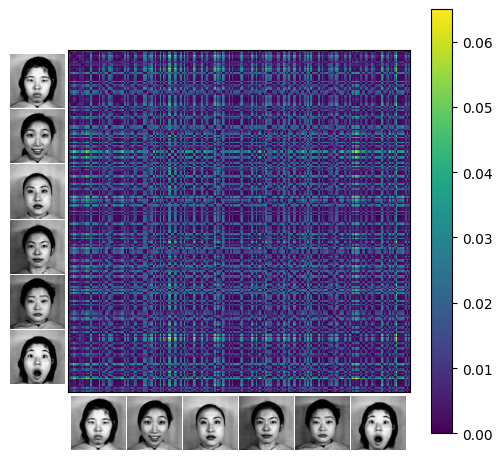

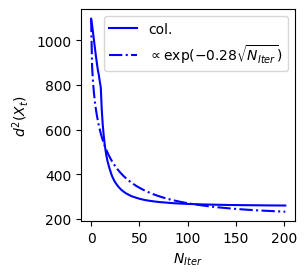

In [11]:
fig = plot_japanese_W(Wcoll, data0)
fig.set_size_inches(size*cm*2, size*cm*2)
fig.savefig('coll_Japanese_64t64.pdf',format='pdf', bbox_inches="tight", dpi=300)

#fig = plot_japanese_W(Wcoll_isa, data0)
#fig.set_size_inches(size*cm*2, size*cm*2)
#fig.savefig('coll_Japanese_64t64.pdf',format='pdf', bbox_inches="tight", dpi=300)


mean = dists_coll_xy
def exponential_function(x, a, b):
    return a*(np.exp(b*x**0.5)-1.) + mean[0]
y = np.array(mean)
x = np.array([i for i in range(len(y))])
initial_guess = [1, -0.1]  # Initial guess for the parameters a and b
params, covariance = curve_fit(exponential_function, x, y, p0=initial_guess)
a_fitted, b_fitted = params
y_fitted = exponential_function(x, a_fitted, b_fitted)

#y = np.array(dists_coll_isa)
#x_isa = np.array([i for i in range(len(y))])
#params_isa, covariance_isa = curve_fit(exponential_function, x_isa, y, p0=initial_guess)
#a_fitted_isa, b_fitted_isa = params_isa
#y_fitted_isa = exponential_function(x_isa, a_fitted_isa, b_fitted_isa)

fig, ax = plt.subplots();
ax.plot(dists_coll_xy,color="blue", label="col.")
#ax.plot(dists_coll_isa,color="red", marker="<", linestyle="", label="ISA")
ax.plot(x, y_fitted, color="blue", label="$\propto \exp("+str(round(b_fitted,2))+r"\sqrt{N_{Iter}})$", linestyle="-.")
#ax.plot(x_isa, y_fitted_isa, color="red", label="$\propto \exp("+str(round(b_fitted_isa,2))+r"\sqrt{N_{Iter}})$", linestyle="-.")
#ax.set_xscale("log")
#ax.set_yscale("log")
plt.legend()
ax.set_xlabel(r'$N_{Iter}$')
ax.set_ylabel(r'$d^2(X_t)$')
#ax.set_ylabel(r'$\sum_{i\neq j} \mathbb{E}[||x^{(i)}-x^{(j)}||_2^2]$')
fig.set_size_inches(size*cm, size*cm)
fig.savefig('evol_Japanese_Niter.pdf',format='pdf', bbox_inches="tight", dpi=300)

K = X.shape[0]
Np = X.shape[1]

'''
fig, ax = plt.subplots();
ax.plot(x*K/2.+1, dists_coll_xy,color="blue", label="col.")
ax.plot(x_isa*(Np-1)/2*(K-1)+1, dists_coll_isa,color="red", label="ISA", marker="<", linestyle="--")
#ax.plot(x, y_fitted, color="black", label="$\propto \exp("+str(round(b_fitted,2))+r"t)$", linestyle="-.")
#ax.plot(x_isa, y_fitted_isa, color="black", label="$\propto \exp("+str(round(b_fitted_isa,2))+r"t)$", linestyle="-.")
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend()
ax.set_xlabel(r'$1+N_\mathrm{col-cand}/N_p$')
ax.set_ylabel(r'$d^2(X_t)$')
#ax.set_ylabel(r'$\sum_{i\neq j} \mathbb{E}[||x^{(i)}-x^{(j)}||_2^2]$')
fig.set_size_inches(size*cm, size*cm)
fig.savefig('evol_Japanese_Ncol.pdf',format='pdf', bbox_inches="tight", dpi=300)
'''

0   1
0   2
0   5


IndexError: index 13 is out of bounds for axis 0 with size 10

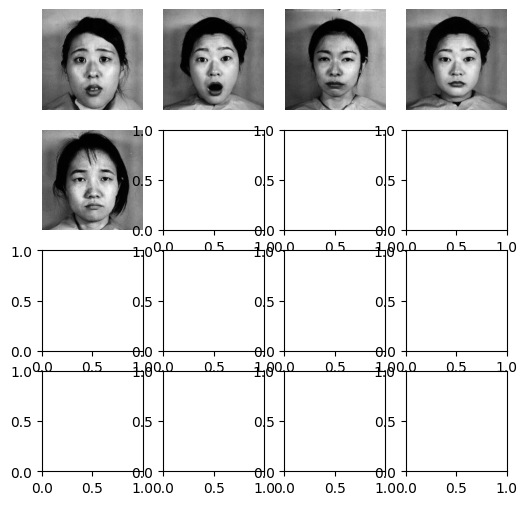

In [22]:
ncol = 4
nrows = 4
i1s = [13*k for k in range(nrows)]

fig, axes = plt.subplots(nrows=nrows, ncols=ncol, figsize=(ncol*1.5,nrows*1.5))

for j in range(nrows):
    i1 = i1s[j]
    axes[j][0].imshow(data0[i1], cmap='gray')
    axes[j][0].axis('off')
    
    i2s = np.argsort((Wcoll + np.eye(Wcoll.shape[0]))[i1,:])    
    for i in range(1,ncol):
        i2 = i2s[i]
        print(i1," ", i2)
        axes[j][i].imshow(data0[i2], cmap='gray')
        axes[j][i].axis('off')

fig.savefig('Japanese_sim_pics_'+str(nrows)+'rows_'+str(ncol)+'cols.pdf',format='pdf', bbox_inches="tight", dpi=300)



In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_japanese_W(W, data_m):
    # Step 2: Create sample images
    image1 = data_m[int(ndata/10),:,:]
    image2 = data_m[2*int(ndata/10),:,:]
    image3 = data_m[3*int(ndata/10),:,:]
    image4 = data_m[4*int(ndata/10),:,:]
    image5 = data_m[5*int(ndata/10),:,:]
    image6 = data_m[6*int(ndata/10),:,:]
    image7 = data_m[7*int(ndata/10),:,:]
    image8 = data_m[8*int(ndata/10),:,:]
    image9 = data_m[9*int(ndata/10),:,:]
    image10 = data_m[10*int(ndata/10),:,:]

    fig, ax = plt.subplots()

    # the matrix as a heatmap
    cax = ax.matshow(W, cmap='viridis')

    # remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Step 5: Add a colorbar to the heatmap
    fig.colorbar(cax)

    # Step 6: Plot additional images outside the matrix plot
    # Define positions for the images
    positions = [(0.02, 0.7), (0.02, 0.6), (0.02, 0.5), (0.02, 0.4), (0.02, 0.3), (0.02, 0.2),
                 (0.13, 0.08), (0.232, 0.08), (0.333, 0.08), (0.435, 0.08), (0.537, 0.08), (0.639, 0.08)]  # x, y positions for images
    images = [image1, image2, image3, image4, image5, image6, image1, image2, image3, image4, image5, image6] #, image1, image2]

    for pos, img in zip(positions, images):
        # Create a new inset axis for each image
        inset_ax = fig.add_axes([pos[0], pos[1], 0.098, 0.098])  # [x, y, width, height]
        inset_ax.imshow(img, cmap='gray')
        inset_ax.axis('off')  # Hide the axis

    return fig

In [34]:
import time
from lib.collision_wrapper import find_OT_collision as newot
import tracemalloc
tracemalloc.start()

X = X00.copy()
X = X[:,:2000,:].copy()

rel_errs = []
rel_errs_sinkhorn = []
rel_errs_sinkhorn2 = []
t_emd = []
t_coll = []
t_sinkhorn = []
t_sinkhorn2 = []
mem_emd = []
mem_coll = []
mem_sinkhorn = []
mem_sinkhorn2 = []

Npairs = 10
print(X.shape)
ids = np.random.choice(X.shape[0], 2*Npairs, replace=False)
id1s = []
id2s = []
for i in range(Npairs):
    if i % 10 == 0:
        print("i=", i)
    id1 = ids[2*i]
    id2 = ids[2*1+1]
    id1s.append(id1)
    id2s.append(id2)
    
    x00 = X[id1,:].copy()
    y00 = X[id2,:].copy()
    tracemalloc.reset_peak()
    
    first_size, first_peak = tracemalloc.get_traced_memory()
    x_emd = x00.copy(); y_emd = y00.copy();
    start_time = time.time()
    x_emd, y_emd = find_optimal_map_nd(x_emd, y_emd)
    first_size, second_peak = tracemalloc.get_traced_memory()
    mem_emd.append(second_peak - first_peak)
    t_emd.append( time.time() - start_time )
    w_emd_xy = np.mean(np.sum((x_emd-y_emd)**2, axis=1))
    del x_emd, y_emd
    
    tracemalloc.reset_peak()
    first_size, first_peak = tracemalloc.get_traced_memory()
    x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
    start_time = time.time()
    x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=0.5)
    first_size, second_peak = tracemalloc.get_traced_memory()
    mem_sinkhorn.append(second_peak - first_peak)
    t_sinkhorn.append( time.time() - start_time )
    w_sinkhorn_xy = np.mean(np.sum((x_sinkhorn-y_sinkhorn)**2, axis=1))
    del x_sinkhorn, y_sinkhorn

    tracemalloc.reset_peak()
    first_size, first_peak = tracemalloc.get_traced_memory()
    x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
    start_time = time.time()
    x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=0.1)
    first_size, second_peak = tracemalloc.get_traced_memory()
    mem_sinkhorn2.append(second_peak - first_peak)
    t_sinkhorn2.append( time.time() - start_time )
    w_sinkhorn_xy2 = np.mean(np.sum((x_sinkhorn-y_sinkhorn)**2, axis=1))
    del x_sinkhorn, y_sinkhorn
    
    tracemalloc.reset_peak()
    first_size, first_peak = tracemalloc.get_traced_memory()
    x_coll = x00.copy(); y_coll = y00.copy();
    start_time = time.time()
    Xt=np.zeros((2,x00.shape[0],x00.shape[1]))
    Xt[0,:,:] = x00.copy()
    Xt[1,:,:] = y00.copy()
    Xt, dists_coll_xy, nt = newot(Xt, MinIter=1000, MaxIter=10000, tol = 1e-6, avg_window=50, Track=1)
    first_size, second_peak = tracemalloc.get_traced_memory()
    mem_coll.append(second_peak - first_peak)
    t_coll.append( time.time() - start_time )

    x_coll = Xt[0,:,:]
    y_coll = Xt[1,:,:]
    
    w_coll_xy = np.mean(np.sum((x_coll-y_coll)**2, axis=1))
    del x_coll, y_coll, Xt, x00, y00
        
    rel_errs.append(abs( w_coll_xy - w_emd_xy ) / w_emd_xy)
    rel_errs_sinkhorn.append(abs( w_sinkhorn_xy - w_emd_xy ) / w_emd_xy)
    rel_errs_sinkhorn2.append(abs( w_sinkhorn_xy2 - w_emd_xy ) / w_emd_xy)
    

(40, 2000, 1)
i= 0


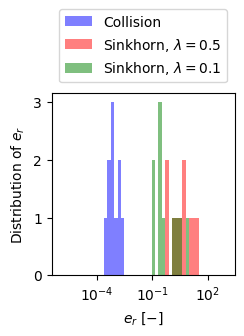

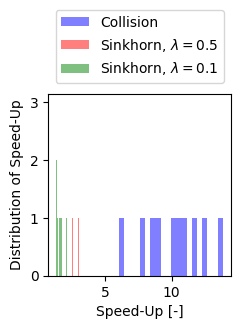

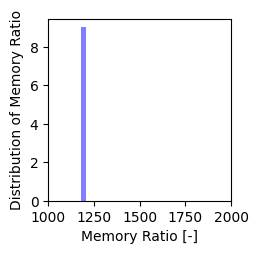

In [35]:
size = 6

rel_errs = np.array( rel_errs )
t_coll = np.array( t_coll )
t_emd = np.array( t_emd )
mem_coll = np.array( mem_coll )
mem_emd = np.array( mem_emd )

rel_errs[rel_errs<1e-15] = 1e-16

xx = [i for i in range(len(rel_errs))]

fig, ax = plt.subplots();
ax.hist(rel_errs, bins=10**np.linspace(-6, 3, 50), color="blue", alpha=0.5, label="Collision")
ax.hist(rel_errs_sinkhorn, bins=10**np.linspace(-6, 3, 50), color="red", alpha=0.5, label="Sinkhorn, $\lambda=0.5$")
ax.hist(rel_errs_sinkhorn2, bins=10**np.linspace(-6, 3, 50), color="green", alpha=0.5, label="Sinkhorn, $\lambda=0.1$")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5))
ax.set_ylabel(r"Distribution of $e_r$")
ax.set_xlabel("$e_r\ [-]$")
ax.set_xscale("log")
fig.set_size_inches(size*cm, size*cm)
#plt.savefig('japanese_dist_rel_error_EMD.pdf',format='pdf', bbox_inches="tight", dpi=300);

#################################3
fig, ax = plt.subplots();
ax.hist(t_emd/t_coll, bins=20, color="blue", alpha=0.5, label="Collision")
ax.hist(t_emd/t_sinkhorn, bins=20, color="red", alpha=0.5, label="Sinkhorn, $\lambda=0.5$")
ax.hist(t_emd/t_sinkhorn2, bins=20, color="green", alpha=0.5, label="Sinkhorn, $\lambda=0.1$")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5))
ax.set_ylabel(r"Distribution of Speed-Up")
ax.set_xlabel("Speed-Up [-]")
fig.set_size_inches(size*cm, size*cm)
#plt.savefig('japanese_dist_speedup_EMD.pdf',format='pdf', bbox_inches="tight", dpi=300);

##################################
fig, ax = plt.subplots();
#_ = ax.hist((mem_emd*1.)/(1.*mem_coll), bins=50, color="blue", alpha=0.5)
_ = ax.hist((mem_emd*1.)/(1.*mem_coll), color="blue", alpha=0.5, bins=10**np.linspace(3, 4, 100))
ax.set_xlim([1e3,2e3])
ax.set_ylabel(r"Distribution of Memory Ratio")
ax.set_xlabel("Memory Ratio [-]")
#ax.ticklabel_format(style='sci', scilimits=(0,0))
#ax.set_xscale("log")

fig.set_size_inches(size*cm, size*cm)
#plt.savefig('japanese_dist_memratio_EMD.pdf',format='pdf', bbox_inches="tight", dpi=300);


In [208]:
np.max(rel_errs_sinkhorn)

152.8380319626504

## cost against number of marginals

In [120]:
import time
from lib.collision_wrapper import find_OT_collision as newot
import tracemalloc
tracemalloc.start()

Nms = [2, 5, 10, 20, 40] #, 80, 160, 213]

X = X00.copy()
navg = 2
ts = [[] for i in range(len(Nms))]
ms = [[] for i in range(len(Nms))]
ts_isa = [[] for i in range(len(Nms))]
ms_isa = [[] for i in range(len(Nms))]
times = [0 for i in range(len(Nms))]
mems = [0 for i in range(len(Nms))]
times_isa = [0 for i in range(len(Nms))]
mems_isa = [0 for i in range(len(Nms))]
w2s = [[[] for k in range(navg)] for i in range(len(Nms))]
w2s_isa = [[[] for k in range(navg)] for i in range(len(Nms))]
for j in range(len(Nms)):
    Nm = Nms[j]
    m = 0
    t = 0
    m_isa = 0
    t_isa = 0
    for k in range(navg):
        print("rep: ", k, flush=True)
        tracemalloc.reset_peak()
        first_size, first_peak = tracemalloc.get_traced_memory()
        Xt = X[:Nm,:,:].copy()
        start_time = time.time()
        Xt, dists_coll_xy, nt = newot(Xt, MinIter=200, MaxIter=200, tol = 1e-3, avg_window=20, Track=1, resh_freq=10)
        #Xt, ids, dists_coll_xy, nt, Jt = find_OT_collision_nd_nmargins_new(Xt, Total_Cost=total_cost,  Change_Cost=change_cost, MinIter=2, MaxIter=2, tol = 1e-6, avg_window=20)
        t += time.time() - start_time
        ts[j].append(time.time() - start_time)
        print("col time:", time.time() - start_time)
        first_size, second_peak = tracemalloc.get_traced_memory()
        m += second_peak - first_peak
        ms[j].append(second_peak - first_peak)
        w2s[j][k] = dists_coll_xy
        
        tracemalloc.reset_peak()
        first_size, first_peak = tracemalloc.get_traced_memory()
        Xt = X[:Nm,:,:].copy()
        start_time = time.time()
        Xt, dists_coll_xy, nt = ISA(Xt, MinIter=2, MaxIter=5, tol = 1e-3, avg_window=1, Track=1)
        #Xt, ids, dists_coll_xy, nt, Jt = find_OT_collision_nd_nmargins_new(Xt, Total_Cost=total_cost,  Change_Cost=change_cost, MinIter=2, MaxIter=2, tol = 1e-6, avg_window=20)
        t_isa += time.time() - start_time
        print("ISA time:", time.time() - start_time)
        ts_isa[j].append(time.time() - start_time)
        first_size, second_peak = tracemalloc.get_traced_memory()
        m_isa += second_peak - first_peak
        ms_isa[j].append(second_peak - first_peak)
        w2s_isa[j][k] = dists_coll_xy

    mems[j] = m/(1.*navg)
    times[j] = t/(1.*navg)

    mems_isa[j] = m_isa/(1.*navg)
    times_isa[j] = t_isa/(1.*navg)
    
    print(r"Nm:", Nm, flush=True)
    del Xt, dists_coll_xy

times = np.array(times)
mems = np.array(mems)
ts = np.array(ts)
ms = np.array(ms)
times_isa = np.array(times_isa)
mems_isa = np.array(mems_isa)
ts_isa = np.array(ts_isa)
ms_isa = np.array(ms_isa)
print(ts.shape)

rep:  0
col time: 0.01572895050048828
ISA time: 0.3006594181060791
rep:  1
col time: 0.011800527572631836
ISA time: 0.28979969024658203
Nm: 2
rep:  0
col time: 0.07318902015686035
ISA time: 2.41545033454895
rep:  1
col time: 0.07581186294555664
ISA time: 2.285910129547119
Nm: 5
rep:  0
col time: 0.2724578380584717
ISA time: 11.019535303115845
rep:  1
col time: 0.25989627838134766
ISA time: 11.009867668151855
Nm: 10
rep:  0
col time: 1.038358449935913
ISA time: 55.30354452133179
rep:  1
col time: 1.0256950855255127
ISA time: 51.47518801689148
Nm: 20
rep:  0
col time: 4.774736404418945
ISA time: 259.7633755207062
rep:  1
col time: 4.517454385757446
ISA time: 257.8386824131012
Nm: 40
(5, 2)


In [65]:
ts  = ts/100.*20.

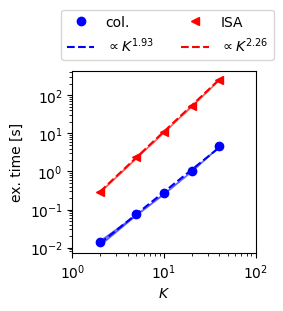

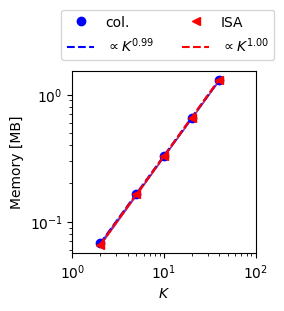

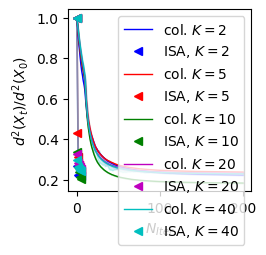

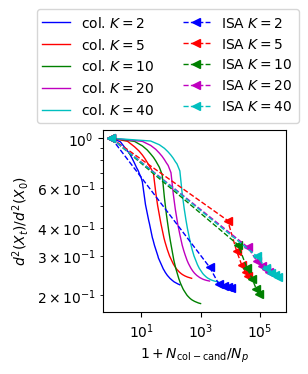

In [123]:
from scipy.stats import linregress

def fit_xp(x, y, xt=None):
    log_x = np.log10(x)
    log_y = np.log10(y)
    if xt is None:
        xt = x.copy()
    log_xt =  np.log10(xt)

    slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
    slope_str = f'{slope:.2f}'

    fitted_y = 10**(intercept + slope * log_xt)
    return slope, slope_str, fitted_y

fig, ax = plt.subplots();

ax.fill_between(Nms, np.mean(ts,axis=1)-np.var(ts,axis=1)**0.5, np.mean(ts,axis=1)+np.var(ts,axis=1)**0.5, color="blue", alpha=0.5)
ax.plot(Nms, np.mean(ts,axis=1), marker="o", color="blue", linewidth=0, label="col.")
slope_coll, slope_coll_str, ex_time_coll_fit_y = fit_xp(Nms, times)
ax.plot(Nms, ex_time_coll_fit_y, label=r'$\propto K^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.fill_between(Nms, np.mean(ts_isa,axis=1)-np.var(ts_isa,axis=1)**0.5, np.mean(ts_isa,axis=1)+np.var(ts_isa,axis=1)**0.5, color="red", alpha=0.5)
ax.plot(Nms, np.mean(ts_isa,axis=1), marker="<", color="red", linewidth=0, label="ISA")
slope_coll, slope_coll_str, ex_time_coll_fit_y = fit_xp(Nms, times_isa)
ax.plot(Nms, ex_time_coll_fit_y, label=r'$\propto K^{'+slope_coll_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_xticks([1,100],[r'$10$',r'$10^2$'])
ax.set_xlim([1,100])
ax.set_xlabel(r"$K$")
ax.set_ylabel(r"ex. time [s]")
ax.legend(loc='center left', bbox_to_anchor=(-0.1, 1.2),ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('JapaneseData_time_vs_K.pdf',format='pdf', bbox_inches="tight", dpi=300);

fig, ax = plt.subplots();

mems = np.array(mems)
ax.plot(Nms, np.mean(ms/1e6,axis=1), marker="o", color="blue", linewidth=0, label="col.")
ax.fill_between(Nms, np.mean(ms/1e6,axis=1)-np.var(ms/1e6,axis=1)**0.5, np.mean(ms/1e6,axis=1)+np.var(ms/1e6,axis=1)**0.5, color="blue", alpha=0.5)
slope_coll, slope_coll_str, ex_time_coll_fit_y = fit_xp(Nms, mems/1e6)
ax.plot(Nms, ex_time_coll_fit_y, label=r'$\propto K^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ms_isa = np.array(ms_isa)
mems_isa = np.array(mems_isa)
ax.plot(Nms, np.mean(ms_isa/1e6,axis=1), marker="<", color="red", linewidth=0, label="ISA")
ax.fill_between(Nms, np.mean(ms_isa/1e6,axis=1)-np.var(ms_isa/1e6,axis=1)**0.5, np.mean(ms_isa/1e6,axis=1)+np.var(ms_isa/1e6,axis=1)**0.5, color="red", alpha=0.5)
slope_coll, slope_coll_str, ex_time_coll_fit_y = fit_xp(Nms, mems_isa/1e6)
ax.plot(Nms, ex_time_coll_fit_y, label=r'$\propto K^{'+slope_coll_str+'}$', color='red', linestyle="--")
plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_xticks([10,100],[r'$10$',r'$10^2$'])
ax.set_xlim([1,100])
ax.set_xlabel(r"$K$")
ax.set_ylabel(r"Memory [MB]")
ax.legend(loc='center left', bbox_to_anchor=(-0.1, 1.2),ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('JapaneseData_memory_vs_K.pdf',format='pdf', bbox_inches="tight", dpi=300);


fig, ax = plt.subplots();
cls = ["blue", "red", "green", "m", "c", "brown", "gray", "salmon", "blueviolet", "lime", "chocolate"]
w2s = np.array(w2s)
w2s_isa = np.array(w2s_isa)
for j in range(len(Nms)):
    mean = np.mean(w2s[j,:,:], axis=0)
    std = np.std(w2s[j,:,:], axis=0)
    mean = mean / mean[0]
    ax.plot(mean, color=cls[j], linewidth=1, label=r"col. $K=$"+str(Nms[j])) #, marker=markers[j], markevery=10)
    plt.fill_between([i for i in range(mean.shape[0])], mean-std, mean+std, color=cls[j], alpha=0.2)
    
    mean = np.mean(w2s_isa[j,:,:], axis=0)
    std = np.std(w2s_isa[j,:,:], axis=0)
    mean = mean / mean[0]
    ax.plot(mean, color=cls[j], linewidth=0, label=r"ISA, $K=$"+str(Nms[j]), marker="<") #, marker=markers[j], markevery=10)
    plt.fill_between([i for i in range(mean.shape[0])], mean-std, mean+std, color=cls[j], alpha=0.2)
plt.legend()
#ax.set_xscale("log")
#ax.set_yscale("log")
#ax.set_xticks([10,100],[r'$10$',r'$10^2$'])
#ax.set_xlim([100,40000])
ax.set_xlabel(r"$N_{Iter}$")
ax.set_ylabel(r'$d^2(X_t)/d^2(X_0)$')
#ax.set_ylabel(r'${\sum_{i\neq j} \mathbb{E}[||x_t^{(i)}-x_t^{(j)}||_2^2]}/{\sum_{i\neq j} \mathbb{E}[||x_0^{(i)}-x_0^{(j)}||_2^2]}$')
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.set_size_inches(size*cm, size*cm)
#plt.savefig('JapaneseData_W2evol.pdf',format='pdf', bbox_inches="tight", dpi=300);

fig, ax = plt.subplots();
for j in range(len(Nms)):
    mean = np.mean(w2s[j,:,:], axis=0)
    std = np.std(w2s[j,:,:], axis=0)
    mean = mean / mean[0]
    xx = np.array([i for i in range(w2s.shape[2])])
    xx = xx*Nms[j]/2.+1
    ax.plot(xx, mean, color=cls[j], linewidth=1, label=r"col. $K=$"+str(Nms[j])) #, marker=markers[j], markevery=10)
    #plt.fill_between(xx, mean-std, mean+std, color=cls[j], alpha=0.2)
    
for j in range(len(Nms)):
    mean = np.mean(w2s_isa[j,:,:], axis=0)
    std = np.std(w2s_isa[j,:,:], axis=0)
    mean = mean / mean[0]
    xx = np.array([i for i in range(w2s_isa.shape[2])])
    xx = xx*(Nms[j]-1)*(Np-1)/2.+1
    ax.plot(xx, mean, color=cls[j], label=r"ISA $K=$"+str(Nms[j]), marker="<", linewidth=1, linestyle="--") #, marker=markers[j], markevery=10)
    #plt.fill_between(xx, mean-std, mean+std, color=cls[j], alpha=0.2)

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc='center left', bbox_to_anchor=(-0.4, 1.35),ncol=2)
ax.set_xlabel(r'$1+N_\mathrm{col-cand}/N_p$')
ax.set_ylabel(r'$d^2(X_t)/d^2(X_0)$')
#ax.set_ylabel(r'$\sum_{i\neq j} \mathbb{E}[||x^{(i)}-x^{(j)}||_2^2]$')
fig.set_size_inches(size*cm, size*cm)
fig.savefig('evol_Japanese_Ncol_vs_K.pdf',format='pdf', bbox_inches="tight", dpi=300)

In [88]:
xx

array([ True])

/tmp/ipykernel_13658/4076050662.py:7: RuntimeWarning: divide by zero encountered in divide
  ax.plot(mean/mean[0], color=cls[j], linewidth=2, label=r"$N_m=$"+str(Nms[j]))
/tmp/ipykernel_13658/4076050662.py:7: RuntimeWarning: invalid value encountered in divide
  ax.plot(mean/mean[0], color=cls[j], linewidth=2, label=r"$N_m=$"+str(Nms[j]))
/tmp/ipykernel_13658/4076050662.py:8: RuntimeWarning: divide by zero encountered in divide
  plt.fill_between([i for i in range(mean.shape[0])], mean/mean[0]-std, mean/mean[0]+std, color=cls[j], alpha=0.2)
/tmp/ipykernel_13658/4076050662.py:8: RuntimeWarning: invalid value encountered in divide
  plt.fill_between([i for i in range(mean.shape[0])], mean/mean[0]-std, mean/mean[0]+std, color=cls[j], alpha=0.2)
/tmp/ipykernel_13658/4076050662.py:7: RuntimeWarning: divide by zero encountered in divide
  ax.plot(mean/mean[0], color=cls[j], linewidth=2, label=r"$N_m=$"+str(Nms[j]))
/tmp/ipykernel_13658/4076050662.py:7: RuntimeWarning: invalid value encounter

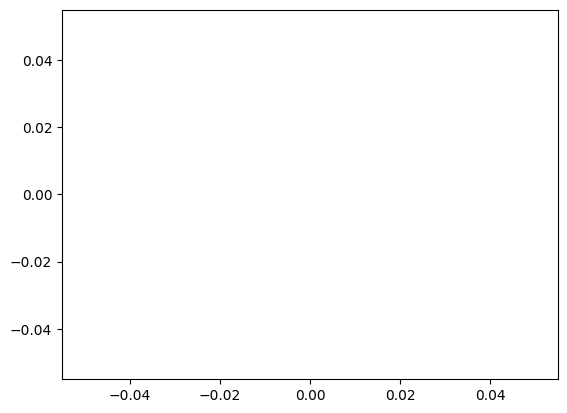

In [69]:
fig, ax = plt.subplots();

w2s = np.array(w2s)
for j in range(len(Nms)):
    mean = np.mean(w2s[j,:,:], axis=0)
    std = np.std(w2s[j,:,:], axis=0)
    ax.plot(mean/mean[0], color=cls[j], linewidth=2, label=r"$N_m=$"+str(Nms[j]))
    plt.fill_between([i for i in range(mean.shape[0])], mean/mean[0]-std, mean/mean[0]+std, color=cls[j], alpha=0.2)

## Cost/error against Np compared to EMD

In [44]:
import time
from lib.collision_wrapper import find_OT_collision as newot
import tracemalloc
tracemalloc.start()

# data0 (213, 256, 256)

everys = [6, 5, 4, 3, 2]

errors_xy = []

mem_emd  = []
mem_sinkhorn  = []
mem_sinkhorn2  = []
mem_coll = []
mem_isa = []
ex_time_emd  = []
ex_time_sinkhorn  = []
ex_time_sinkhorn2  = []
ex_time_coll = []
ex_time_isa = []
iter_coll_xy = []
hist_coll_w = [[] for i in range(len(everys))]
err_hist_coll_w = [[] for i in range(len(everys))]
hist_isa_w = [[] for i in range(len(everys))]
err_hist_isa_w = [[] for i in range(len(everys))]

k=0
navg = 4
Nps = []
print("data0 shape: ", data0.shape)
for every in everys:
  Np = data0[0,::every,::every].shape[0] * data0[0,::every,::every].shape[1]
  Nps.append( Np )
  print("every: ", every, " Np: ", Np, " shape", data0[0,::every,::every].shape)
  
  k = k + 1

  emd_t = 0
  sinkhorn_t = 0
  sinkhorn2_t = 0
  coll_t = 0
  isa_t = 0
  nt_xy_ = 0
  nt_yz_ = 0
  emd_avgmem = 0.0
  sinkhorn_avgmem = 0.0
  sinkhorn2_avgmem = 0.0
  coll_avgmem = 0.0
  isa_avgmem = 0.0
  for av in range(navg):
      id_12 = np.random.choice(data0.shape[0], 2, replace=False)
      x00 = data0[id_12[0],::every,::every]
      y00 = data0[id_12[1],::every,::every]
      x00 = x00.reshape(x00.shape[0]*x00.shape[1], 1)
      y00 = y00.reshape(y00.shape[0]*y00.shape[1], 1)
    
      ## compute EMD
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_emd = x00.copy(); y_emd = y00.copy();
      start_time = time.time()
      x_emd, y_emd = find_optimal_map_nd(x_emd, y_emd)
      first_size, second_peak = tracemalloc.get_traced_memory()
      emd_avgmem += second_peak - first_peak
      emd_t += time.time() - start_time
      print("EMD Done")
      w_emd_xy = np.mean(np.sum((x_emd-y_emd)**2, axis=1))
      del x_emd, y_emd

      ## compute Sinkhorn
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
      start_time = time.time()
      x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=0.1)
      first_size, second_peak = tracemalloc.get_traced_memory()
      sinkhorn_avgmem += second_peak - first_peak
      sinkhorn_t += time.time() - start_time
      print("Sinkhorn Done")
      del x_sinkhorn, y_sinkhorn
    
      ## compute Sinkhorn
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
      start_time = time.time()
      x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=0.05)
      first_size, second_peak = tracemalloc.get_traced_memory()
      sinkhorn2_avgmem += second_peak - first_peak
      sinkhorn2_t += time.time() - start_time
      print("Sinkhorn2 Done")
      del x_sinkhorn, y_sinkhorn

      ## compute collision based
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      start_time = time.time()
      X=np.zeros((2,x00.shape[0],x00.shape[1]))
      X[0,:,:] = x00.copy()
      X[1,:,:] = y00.copy()
      X, dists_coll_xy, nt = newot(X, MinIter=1000, MaxIter=1000, tol = 1e-9, avg_window=20, Track=1, resh_freq=10)
      first_size, second_peak = tracemalloc.get_traced_memory()
      coll_avgmem += second_peak - first_peak
      coll_t += time.time() - start_time
      hist_coll_w[k-1].append(np.array( (dists_coll_xy)) )
      err_hist_coll_w[k-1].append( abs( np.array( (dists_coll_xy)) - w_emd_xy) )
      print("coll Done")
      del X

      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      start_time = time.time()
      X=np.zeros((2,x00.shape[0],x00.shape[1]))
      X[0,:,:] = x00.copy()
      X[1,:,:] = y00.copy()
      X, dists_coll_xy, nt = ISA(X, MinIter=2, MaxIter=10, tol = 1e-3, avg_window=1, Track=1)
      first_size, second_peak = tracemalloc.get_traced_memory()
      isa_avgmem += second_peak - first_peak
      isa_t += time.time() - start_time
    
      hist_isa_w[k-1].append(np.array( (dists_coll_xy)) )
      err_hist_isa_w[k-1].append( abs( np.array( (dists_coll_xy)) - w_emd_xy) )
      print("ISA Done")
      del X
    

  iter_coll_xy.append(nt_xy_/navg)
  mem_emd.append(emd_avgmem/navg)
  mem_coll.append(coll_avgmem/navg)
  mem_isa.append(isa_avgmem/navg)
  mem_sinkhorn.append(sinkhorn_avgmem/navg)
  mem_sinkhorn2.append(sinkhorn2_avgmem/navg)
  ex_time_emd.append(emd_t/navg)
  ex_time_coll.append(coll_t/navg)
  ex_time_isa.append(isa_t/navg)
  ex_time_sinkhorn.append(sinkhorn_t/navg)
  ex_time_sinkhorn2.append(sinkhorn2_t/navg)

data0 shape:  (213, 256, 256)
every:  6  Np:  1849  shape (43, 43)
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
ISA Done
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
ISA Done
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
ISA Done
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
ISA Done
every:  5  Np:  2704  shape (52, 52)
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
ISA Done
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
ISA Done
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
ISA Done
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
ISA Done
every:  4  Np:  4096  shape (64, 64)
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
ISA Done
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
ISA Done
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
ISA Done
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
ISA Done
every:  3  Np:  7396  shape (86, 86)
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
ISA Done
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
ISA Done
EMD Done
Sinkhorn Done
S

sinkhorn: [0.35076773166656494, 0.5121743083000183, 1.1569385528564453, 3.43646776676178, 15.401033639907837]
emd: [0.5869355201721191, 1.1283201575279236, 3.641755223274231, 8.763377070426941, 72.56316447257996]


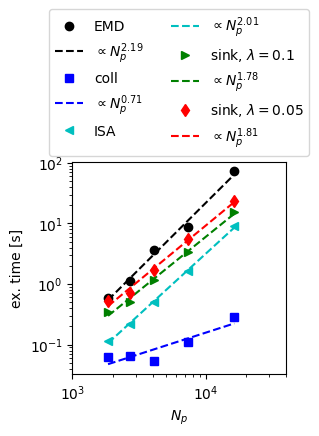

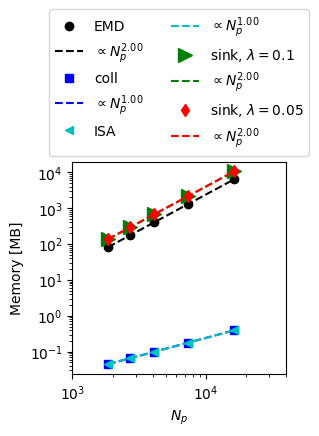

In [45]:
from scipy.stats import linregress

print("sinkhorn:", ex_time_sinkhorn)
print("emd:", ex_time_emd)
def fit_xp(x, y):
    log_x = np.log10(x)
    log_y = np.log10(y)

    slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
    slope_str = f'{slope:.2f}'

    fitted_y = 10**(intercept + slope * log_x)
    return slope, slope_str, fitted_y

###############################################
fig, ax = plt.subplots();

ax.plot(Nps, ex_time_emd, color="black", marker="o", label="EMD", linewidth=0)
slope_emd, slope_emd_str, ex_time_emd_fit_y = fit_xp(Nps, ex_time_emd)
ax.plot(Nps, ex_time_emd_fit_y, label=r'$\propto N_p^{'+slope_emd_str+'}$', color='black', linestyle="--")

ax.plot(Nps, ex_time_coll, color="blue", marker="s", label="coll", linewidth=0)
slope_coll, slope_coll_str, ex_time_coll_fit_y = fit_xp(Nps, ex_time_coll)
ax.plot(Nps, ex_time_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(Nps, ex_time_isa, color="c", marker="<", label="ISA", linewidth=0)
slope_isa, slope_isa_str, ex_time_isa_fit_y = fit_xp(Nps, ex_time_isa)
ax.plot(Nps, ex_time_isa_fit_y, label=r'$\propto N_p^{'+slope_isa_str+'}$', color='c', linestyle="--")

ax.plot(Nps, ex_time_sinkhorn, color="green", marker=">", label=r"sink, $\lambda=0.1$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, ex_time_sinkhorn_fit_y = fit_xp(Nps, ex_time_sinkhorn)
ax.plot(Nps, ex_time_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='green', linestyle="--")

ax.plot(Nps, ex_time_sinkhorn2, color="red", marker="d", label=r"sink, $\lambda=0.05$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, ex_time_sinkhorn_fit_y = fit_xp(Nps, ex_time_sinkhorn2)
ax.plot(Nps, ex_time_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks([1000,10000],[r'$10^3$',r'$10^4$'])
ax.set_xlim([1000,40000])
ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"ex. time [s]")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.75), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('Japanese_ex_time_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

###############################################
fig, ax = plt.subplots();

ax.plot(Nps, np.array(mem_emd)/1e6, color="black", marker="o", label="EMD", linewidth=0)
slope_emd, slope_emd_str, mem_emd_fit_y = fit_xp(Nps, np.array(mem_emd)/1e6)
ax.plot(Nps, mem_emd_fit_y, label=r'$\propto N_p^{'+slope_emd_str+'}$', color='black', linestyle="--")

ax.plot(Nps, np.array(mem_coll)/1e6, color="blue", marker="s", label="coll", linewidth=0)
slope_coll, slope_coll_str, mem_coll_fit_y = fit_xp(Nps, np.array(mem_coll)/1e6)
ax.plot(Nps, mem_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(Nps, np.array(mem_isa)/1e6, color="c", marker="<", label="ISA", linewidth=0)
slope_isa, slope_isa_str, mem_isa_fit_y = fit_xp(Nps, np.array(mem_isa)/1e6)
ax.plot(Nps, mem_isa_fit_y, label=r'$\propto N_p^{'+slope_isa_str+'}$', color='c', linestyle="--")

ax.plot(Nps, np.array(mem_sinkhorn)/1e6, color="green", marker=">", label=r"sink, $\lambda=0.1$", linewidth=0, markersize=10)
slope_sinkhorn, slope_sinkhorn_str, mem_sinkhorn_fit_y = fit_xp(Nps, np.array(mem_sinkhorn)/1e6)
ax.plot(Nps, mem_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='green', linestyle="--")

ax.plot(Nps, np.array(mem_sinkhorn2)/1e6, color="red", marker="d", label=r"sink, $\lambda=0.05$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, mem_sinkhorn_fit_y = fit_xp(Nps, np.array(mem_sinkhorn2)/1e6)
ax.plot(Nps, mem_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xticks([1000,10000],[r'$10^3$',r'$10^4$'])
ax.set_xlim([1000,40000])

ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"Memory [MB]")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.75), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('Japanese_mem_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);


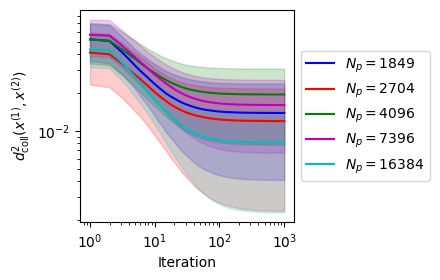

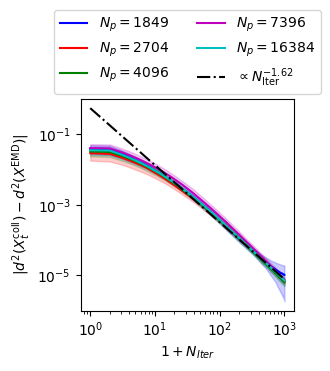

In [42]:
def fit_exp(x, y, test=None):
    log_x = np.log(x)
    log_y = np.log(y)
    if test is None:
        test = log_x
    else:
        test = np.log(test)

    slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
    slope_str = f'{slope:.2f}'

    fitted_y = np.exp(intercept + slope * test)
    return slope, slope_str, fitted_y

fig, ax = plt.subplots();
cls = ["blue", "red", "green", "m", "c", "brown", "gray", "salmon", "blueviolet", "lime", "chocolate"]
for k in range(len(Nps)):
    nmin = 10000000
    for jj in range(len(hist_coll_w[k])):
      if len(hist_coll_w[k][jj]) < nmin:
        nmin = len(hist_coll_w[k][jj])-1
    hist_coll_w_k = np.zeros( (len(hist_coll_w[k]), nmin) )
    for jj in range(len(hist_coll_w[k])):
      for ii in range(nmin):
        hist_coll_w_k[jj,ii] = hist_coll_w[k][jj][ii]
    xx = [i+1 for i in range(nmin)]
    mean_err = np.mean(hist_coll_w_k, axis=0)
    std_err = np.var(hist_coll_w_k,axis=0)**0.5
    ax.plot(xx, mean_err, color=cls[k], markevery=100, label=r"$N_p="+str(Nps[k])+"$")
    plt.fill_between(xx, mean_err-std_err, mean_err+std_err, color=cls[k], alpha=0.2)
    #for av in range(navg):
    #    ax.plot(hist_coll_w[k][av], color=cls[k], marker=markers[av], markevery=100, label=r"$N_p="+str(Nps[k])+"\ rep.\ "+str(av+1)+"$")

t = np.array([i+1 for i in range(len(mean_err))])
ts = np.array([i+1 for i in range(len(mean_err))])
slope, slope_str, fitted_y = fit_exp(t, mean_err, test=ts)
#ax.plot(ts, fitted_y, color="black", linestyle="-.", label=r"$\propto \exp("+slope_str+"t)$")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$d^2_\mathrm{coll}({x}^{(1)},{x}^{(2)})$")

ax.set_xlabel("Iteration")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.set_size_inches(size*cm, size*cm)
#plt.savefig('Japanese_evol_error_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

fig, ax = plt.subplots();
for k in range(len(Nps)):
    nmin = 10000000
    for jj in range(len(err_hist_coll_w[k])):
      if len(err_hist_coll_w[k][jj]) < nmin:
        nmin = len(err_hist_coll_w[k][jj])-1
    err_hist_coll_w_k = np.zeros( (len(err_hist_coll_w[k]), nmin) )
    for jj in range(len(hist_coll_w[k])):
      for ii in range(nmin):
        err_hist_coll_w_k[jj,ii] = err_hist_coll_w[k][jj][ii]
    xx = [i+1 for i in range(nmin)]
    mean_err = np.mean(err_hist_coll_w_k, axis=0)
    std_err = np.var(err_hist_coll_w_k,axis=0)**0.5
    ax.plot(xx, mean_err, color=cls[k], markevery=100, label=r"$N_p="+str(Nps[k])+"$")
    plt.fill_between(xx, mean_err-std_err, mean_err+std_err, color=cls[k], alpha=0.2)
    #for av in range(navg):
    #    ax.plot(hist_coll_w[k][av], color=cls[k], marker=markers[av], markevery=100, label=r"$N_p="+str(Nps[k])+"\ rep.\ "+str(av+1)+"$")

Niter= np.array([i+1 for i in range(len(mean_err))])
slope, slope_str, fitted_y = fit_exp(Niter, mean_err)
ax.plot(Niter, fitted_y, color="black", linestyle="-.", label=r"$\propto N_\mathrm{Iter}^{"+slope_str+"}$")

ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_ylabel(r"$| d^2_\mathrm{coll}({x}^{(1)},{x}^{(2)}) - d^2_\mathrm{EMD}({x}^{(1)},{x}^{(2)})|$")
ax.set_ylabel(r"$| d^2(X_t^\mathrm{coll}) - d^2(X^\mathrm{EMD})|$")
ax.set_xlabel(r"$1+N_{Iter}$")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.45), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('Japanese_evol_rel_error_EMD_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

# Butterfly

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_butterfly_W(W, data_m):
    # Step 2: Create sample images
    image1 = data_m[int(ndata/10)]
    image2 = data_m[2*int(ndata/10)]
    image3 = data_m[3*int(ndata/10)]
    image4 = data_m[4*int(ndata/10)]
    image5 = data_m[5*int(ndata/10)]
    image6 = data_m[6*int(ndata/10)]
    image7 = data_m[7*int(ndata/10)]
    image8 = data_m[8*int(ndata/10)]
    image9 = data_m[9*int(ndata/10)]
    image10 = data_m[10*int(ndata/10)]

    fig, ax = plt.subplots()

    # the matrix as a heatmap
    cax = ax.matshow(W, cmap='viridis')

    # remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Step 5: Add a colorbar to the heatmap
    fig.colorbar(cax)

    # Step 6: Plot additional images outside the matrix plot
    # Define positions for the images
    positions = [(0.02, 0.7), (0.02, 0.6), (0.02, 0.5), (0.02, 0.4), (0.02, 0.3), (0.02, 0.2),
                 (0.13, 0.08), (0.232, 0.08), (0.333, 0.08), (0.435, 0.08), (0.537, 0.08), (0.639, 0.08)]  # x, y positions for images
    images = [image1, image2, image3, image4, image5, image6, image1, image2, image3, image4, image5, image6] #, image1, image2]

    for pos, img in zip(positions, images):
        # Create a new inset axis for each image
        inset_ax = fig.add_axes([pos[0], pos[1], 0.098, 0.098])  # [x, y, width, height]
        inset_ax.imshow(img)
        inset_ax.axis('off')  # Hide the axis

    return fig

In [4]:
import os
import random
import shutil
from PIL import Image
from scipy.optimize import curve_fit

def collect_images(source_dir, num_images_per_class=5):
    # Make sure the target directory exists
    #os.makedirs(target_dir, exist_ok=True)

    # Get a list of all directories in the source folder
    all_classes = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    # Sort the class directories for consistency
    all_classes.sort()

    total_images_collected = 0
    data0 = []
    data1 = []
    
    # Go through each directory (class)
    for class_dir in all_classes:
        class_path = os.path.join(source_dir, class_dir)
        # Get all image files in the current class directory
        image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]

        # Randomly select a subset of images from the class
        selected_images = random.sample(image_files, min(num_images_per_class, len(image_files)))

        # Copy the selected images to the target directory
        k = 0
        for image_name in selected_images:
            image_path = os.path.join(class_path, image_name)
            image = Image.open(image_path)
            image = np.array(image)
            data0.append(image)
            if image.ndim == 3:
                data1.append(image.reshape(image.shape[0]*image.shape[1], 3))
        
                total_images_collected += 1
                k = k +1
            if(k==4):
                break

    print(f"Total images collected: {total_images_collected}")
    return data0, data1

# Example usage
source_directory = 'Butterfly200/'

data0, data1 = collect_images(source_directory)

Total images collected: 800


In [18]:
print(len(data1))

800


In [6]:
train_data = []
Np = 4000
ids = np.random.choice(100000, Np, replace=False)
for i in range(4*25): #range(len(data1)):
    train_data.append(data1[i][ids,:])
train_data = np.array(train_data) / 256.0
print(train_data.shape)

(100, 4000, 3)


In [7]:
from lib.collision_wrapper import find_OT_collision as newot
import time

X = train_data.copy()
start_time = time.time()
X, dists_coll_xy, nt = newot(X, MinIter=200, MaxIter=200, tol = 1e-3, avg_window=20, Track=1, resh_freq=10)
print(time.time() - start_time)

310.92046570777893


In [18]:
from lib.collision_wrapper import find_OT_ISA as ISA
X_isa = train_data.copy()
start_time = time.time()
X_isa, dists_coll_isa, nt = ISA(X_isa, MinIter=2, MaxIter=10, tol = 1e-3, Track=1)
print(time.time() - start_time)

603.9437975883484


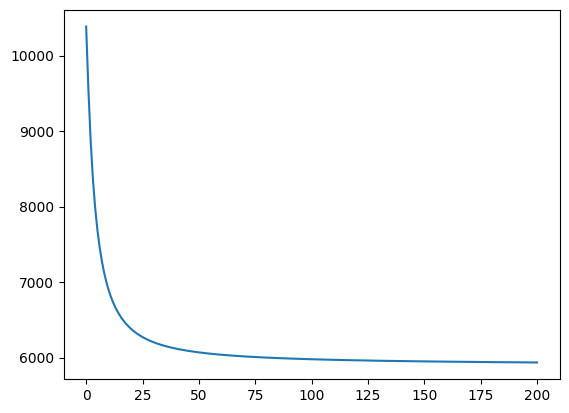

In [36]:
from lib.collision_wrapper import find_OT_collision as newot

X = train_data.copy()
X, dists_coll_xy = newot(X, MinIter=200, MaxIter=200, tol = 1e-9, avg_window=20)

plt.plot(dists_coll_xy)

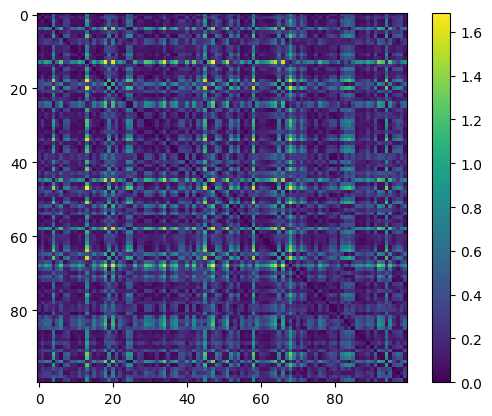

In [8]:
ndata = X.shape[0]
Wcoll = np.zeros((ndata,ndata))
#Wcoll_isa = np.zeros((ndata,ndata))
for i in range(ndata):
  for j in range(i, ndata):
    Wcoll[i,j] = np.mean(np.sum((X[i,:,:]-X[j,:,:])**2, axis=1))
    Wcoll[j,i] = Wcoll[i,j]
    
    #Wcoll_isa[i,j] = np.mean(np.sum((X_isa[i,:,:]-X_isa[j,:,:])**2, axis=1))
    #Wcoll_isa[j,i] = Wcoll_isa[i,j]

plt.figure()
plt.imshow(Wcoll)
plt.colorbar()

#plt.figure()
#plt.imshow(Wcoll_isa)
#plt.colorbar()

/tmp/ipykernel_11295/3718605899.py:72: RuntimeWarning: overflow encountered in exp
  return a*(np.exp(b*x**0.5)-1.) + mean[0]
/tmp/ipykernel_11295/3718605899.py:72: RuntimeWarning: overflow encountered in multiply
  return a*(np.exp(b*x**0.5)-1.) + mean[0]


'\nmean = dists_coll_xy\ndef exponential_function(x, a, b):\n    return a*(np.exp(b*x**0.5)-1.) + mean[0]\ny = np.array(mean)\nx = np.array([i for i in range(len(y))])\ninitial_guess = [1, -0.1]  # Initial guess for the parameters a and b\nparams, covariance = curve_fit(exponential_function, x, y, p0=initial_guess)\na_fitted, b_fitted = params\nprint(a_fitted, b_fitted)\ny_fitted = exponential_function(x, a_fitted, b_fitted)\n\nfig, ax = plt.subplots();\nax.plot(dists_coll_xy,color="blue")\nax.plot(x, y_fitted, color="black", label="$\\propto \\exp("+str(round(b_fitted,2))+r"t)$", linestyle="-.")\nplt.legend()\n#ax.set_xscale("log")\n#ax.set_yscale("log")\nax.set_xlabel(r\'$N_{Iter}$\')\nax.set_ylabel(r\'$d^2(X_t)$\')\nfig.set_size_inches(size*cm, size*cm)\nfig.savefig(\'evol_butterfly_W2_cost.pdf\',format=\'pdf\', bbox_inches="tight", dpi=300)\n'

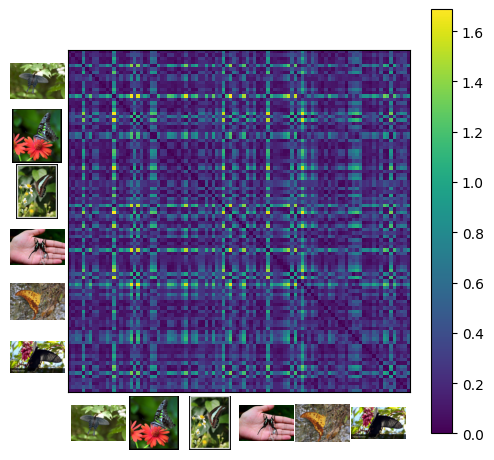

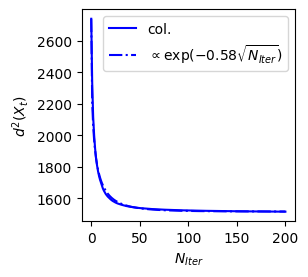

In [9]:
'''
fig = plot_japanese_W(Wcoll, data0)
fig.set_size_inches(size*cm*2, size*cm*2)
#fig.savefig('coll_Japanese_64t64.pdf',format='pdf', bbox_inches="tight", dpi=300)

fig = plot_japanese_W(Wcoll_isa, data0)
fig.set_size_inches(size*cm*2, size*cm*2)
#fig.savefig('coll_Japanese_64t64.pdf',format='pdf', bbox_inches="tight", dpi=300)


mean = dists_coll_xy
def exponential_function(x, a, b):
    return a*(np.exp(b*x**0.5)-1.) + mean[0]
y = np.array(mean)
x = np.array([i for i in range(len(y))])
initial_guess = [1, -0.1]  # Initial guess for the parameters a and b
params, covariance = curve_fit(exponential_function, x, y, p0=initial_guess)
a_fitted, b_fitted = params
y_fitted = exponential_function(x, a_fitted, b_fitted)

y = np.array(dists_coll_isa)
x_isa = np.array([i for i in range(len(y))])
params_isa, covariance_isa = curve_fit(exponential_function, x_isa, y, p0=initial_guess)
a_fitted_isa, b_fitted_isa = params_isa
y_fitted_isa = exponential_function(x_isa, a_fitted_isa, b_fitted_isa)

fig, ax = plt.subplots();
ax.plot(dists_coll_xy,color="blue", label="col.")
ax.plot(dists_coll_isa,color="red", marker="<", linestyle="", label="ISA")
ax.plot(x, y_fitted, color="blue", label="$\propto \exp("+str(round(b_fitted,2))+r"\sqrt{N_{iter}})$", linestyle="-.")
ax.plot(x_isa, y_fitted_isa, color="red", label="$\propto \exp("+str(round(b_fitted_isa,2))+r"\sqrt{N_{iter}})$", linestyle="-.")
#ax.set_xscale("log")
#ax.set_yscale("log")
plt.legend()
ax.set_xlabel(r'$N_{Iter}$')
ax.set_ylabel(r'$d^2(X_t)$')
#ax.set_ylabel(r'$\sum_{i\neq j} \mathbb{E}[||x^{(i)}-x^{(j)}||_2^2]$')
fig.set_size_inches(size*cm, size*cm)
fig.savefig('evol_Japanese_Niter.pdf',format='pdf', bbox_inches="tight", dpi=300)

K = X.shape[0]
Np = X.shape[1]

fig, ax = plt.subplots();
ax.plot(x*K/2.+1, dists_coll_xy,color="blue", label="col.")
ax.plot(x_isa*(Np-1)/2*(K-1)+1, dists_coll_isa,color="red", label="ISA", marker="<", linestyle="--")
#ax.plot(x, y_fitted, color="black", label="$\propto \exp("+str(round(b_fitted,2))+r"t)$", linestyle="-.")
#ax.plot(x_isa, y_fitted_isa, color="black", label="$\propto \exp("+str(round(b_fitted_isa,2))+r"t)$", linestyle="-.")
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend()
ax.set_xlabel(r'$N_\mathrm{col-cand}/N_p$')
ax.set_ylabel(r'$d^2(X_t)$')
#ax.set_ylabel(r'$\sum_{i\neq j} \mathbb{E}[||x^{(i)}-x^{(j)}||_2^2]$')
fig.set_size_inches(size*cm, size*cm)
fig.savefig('evol_Japanese_Ncol.pdf',format='pdf', bbox_inches="tight", dpi=300)

'''

fig = plot_butterfly_W(Wcoll, data0)
fig.set_size_inches(size*cm*2, size*cm*2)
#fig.savefig('coll_butterfly_W2_4k.pdf',format='pdf', bbox_inches="tight", dpi=300)


#fig = plot_butterfly_W(Wcoll_isa, data0)
#fig.set_size_inches(size*cm*2, size*cm*2)
#fig.savefig('coll_butterfly_W2_4k.pdf',format='pdf', bbox_inches="tight", dpi=300)


mean = dists_coll_xy
def exponential_function(x, a, b):
    return a*(np.exp(b*x**0.5)-1.) + mean[0]
y = np.array(mean)
x = np.array([i for i in range(len(y))])
initial_guess = [1, -0.1]  # Initial guess for the parameters a and b
params, covariance = curve_fit(exponential_function, x, y, p0=initial_guess)
a_fitted, b_fitted = params
y_fitted = exponential_function(x, a_fitted, b_fitted)

#y = np.array(dists_coll_isa)
#x_isa = np.array([i for i in range(len(y))])
#params_isa, covariance_isa = curve_fit(exponential_function, x_isa, y, p0=initial_guess)
#a_fitted_isa, b_fitted_isa = params_isa
#y_fitted_isa = exponential_function(x_isa, a_fitted_isa, b_fitted_isa)

fig, ax = plt.subplots();
ax.plot(dists_coll_xy,color="blue", label="col.")
#ax.plot(dists_coll_isa,color="red", marker="<", linestyle="", label="ISA")
ax.plot(x, y_fitted, color="blue", label="$\propto \exp("+str(round(b_fitted,2))+r"\sqrt{N_{Iter}})$", linestyle="-.")
#ax.plot(x_isa, y_fitted_isa, color="red", label="$\propto \exp("+str(round(b_fitted_isa,2))+r"\sqrt{N_{Iter}})$", linestyle="-.")
#ax.set_xscale("log")
#ax.set_yscale("log")
plt.legend()
ax.set_xlabel(r'$N_{Iter}$')
ax.set_ylabel(r'$d^2(X_t)$')
#ax.set_ylabel(r'$\sum_{i\neq j} \mathbb{E}[||x^{(i)}-x^{(j)}||_2^2]$')
fig.set_size_inches(size*cm, size*cm)
fig.savefig('evol_butterfly_Niter.pdf',format='pdf', bbox_inches="tight", dpi=300)

K = X.shape[0]
Np = X.shape[1]

'''
fig, ax = plt.subplots();
ax.plot(x*K/2.+1, dists_coll_xy,color="blue", label="col.")
ax.plot(x_isa*(Np-1)/2*(K-1)+1, dists_coll_isa,color="red", label="ISA", marker="<", linestyle="--")
#ax.plot(x, y_fitted, color="black", label="$\propto \exp("+str(round(b_fitted,2))+r"t)$", linestyle="-.")
#ax.plot(x_isa, y_fitted_isa, color="black", label="$\propto \exp("+str(round(b_fitted_isa,2))+r"t)$", linestyle="-.")
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend()
ax.set_xlabel(r'$N_\mathrm{col-cand}/N_p$')
ax.set_ylabel(r'$d^2(X_t)$')
#ax.set_ylabel(r'$\sum_{i\neq j} \mathbb{E}[||x^{(i)}-x^{(j)}||_2^2]$')
fig.set_size_inches(size*cm, size*cm)
fig.savefig('evol_butterfly_Ncol.pdf',format='pdf', bbox_inches="tight", dpi=300)
'''

'''
mean = dists_coll_xy
def exponential_function(x, a, b):
    return a*(np.exp(b*x**0.5)-1.) + mean[0]
y = np.array(mean)
x = np.array([i for i in range(len(y))])
initial_guess = [1, -0.1]  # Initial guess for the parameters a and b
params, covariance = curve_fit(exponential_function, x, y, p0=initial_guess)
a_fitted, b_fitted = params
print(a_fitted, b_fitted)
y_fitted = exponential_function(x, a_fitted, b_fitted)

fig, ax = plt.subplots();
ax.plot(dists_coll_xy,color="blue")
ax.plot(x, y_fitted, color="black", label="$\propto \exp("+str(round(b_fitted,2))+r"t)$", linestyle="-.")
plt.legend()
#ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xlabel(r'$N_{Iter}$')
ax.set_ylabel(r'$d^2(X_t)$')
fig.set_size_inches(size*cm, size*cm)
fig.savefig('evol_butterfly_W2_cost.pdf',format='pdf', bbox_inches="tight", dpi=300)
'''

0   170
0   36
0   4
4   62
4   65
4   103
8   12
8   135
8   74
12   135
12   74
12   36


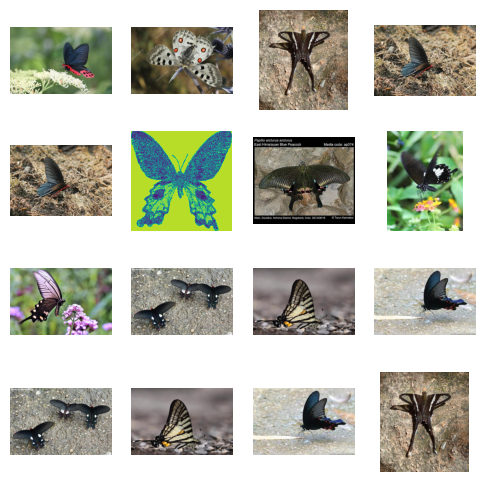

In [32]:
ncol = 4
nrows = 4
i1s = [4*k for k in range(nrows)]

fig, axes = plt.subplots(nrows=nrows, ncols=ncol, figsize=(ncol*1.5,nrows*1.5))

for j in range(nrows):
    i1 = i1s[j]
    axes[j][0].imshow(data0[i1])
    axes[j][0].axis('off')
    
    i2s = np.argsort((Wcoll + np.eye(Wcoll.shape[0]))[i1,:])    
    for i in range(1,ncol):
        i2 = i2s[i]
        print(i1," ", i2)
        axes[j][i].imshow(data0[i2])
        axes[j][i].axis('off')

#fig.savefig('butterfly_sim_pics_'+str(nrows)+'rows_'+str(ncol)+'cols.pdf',format='pdf', bbox_inches="tight", dpi=300)


In [183]:
import time
from lib.collision_wrapper import find_OT_collision as newot
import tracemalloc
tracemalloc.start()

X = train_data.copy()
X = X[:,:2000,:].copy()

rel_errs = []
rel_errs_sinkhorn = []
rel_errs_sinkhorn2 = []
t_emd = []
t_coll = []
t_sinkhorn = []
t_sinkhorn2 = []
mem_emd = []
mem_coll = []
mem_sinkhorn = []
mem_sinkhorn2 = []

Npairs = 200
ids = np.random.choice(X.shape[0], 2*Npairs, replace=False)
id1s = []
id2s = []
for i in range(Npairs):
    if i % 10 == 0:
        print("i=", i)
    id1 = ids[2*i]
    id2 = ids[2*1+1]
    id1s.append(id1)
    id2s.append(id2)
    
    x00 = X[id1,:].copy()
    y00 = X[id2,:].copy()
    tracemalloc.reset_peak()
    
    first_size, first_peak = tracemalloc.get_traced_memory()
    x_emd = x00.copy(); y_emd = y00.copy();
    start_time = time.time()
    x_emd, y_emd = find_optimal_map_nd(x_emd, y_emd)
    first_size, second_peak = tracemalloc.get_traced_memory()
    mem_emd.append(second_peak - first_peak)
    t_emd.append( time.time() - start_time )
    w_emd_xy = np.mean(np.sum((x_emd-y_emd)**2, axis=1))
    del x_emd, y_emd
    
    tracemalloc.reset_peak()
    first_size, first_peak = tracemalloc.get_traced_memory()
    x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
    start_time = time.time()
    x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=0.5)
    first_size, second_peak = tracemalloc.get_traced_memory()
    mem_sinkhorn.append(second_peak - first_peak)
    t_sinkhorn.append( time.time() - start_time )
    w_sinkhorn_xy = np.mean(np.sum((x_sinkhorn-y_sinkhorn)**2, axis=1))
    del x_sinkhorn, y_sinkhorn

    tracemalloc.reset_peak()
    first_size, first_peak = tracemalloc.get_traced_memory()
    x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
    start_time = time.time()
    x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=0.1)
    first_size, second_peak = tracemalloc.get_traced_memory()
    mem_sinkhorn2.append(second_peak - first_peak)
    t_sinkhorn2.append( time.time() - start_time )
    w_sinkhorn_xy2 = np.mean(np.sum((x_sinkhorn-y_sinkhorn)**2, axis=1))
    del x_sinkhorn, y_sinkhorn
    
    tracemalloc.reset_peak()
    first_size, first_peak = tracemalloc.get_traced_memory()
    x_coll = x00.copy(); y_coll = y00.copy();
    start_time = time.time()
    Xt=np.zeros((2,x00.shape[0],x00.shape[1]))
    Xt[0,:,:] = x00.copy()
    Xt[1,:,:] = y00.copy()
    Xt, dists_coll_xy = newot(Xt, MinIter=1000, MaxIter=10000, tol = 1e-6, avg_window=50)
    first_size, second_peak = tracemalloc.get_traced_memory()
    mem_coll.append(second_peak - first_peak)
    t_coll.append( time.time() - start_time )

    x_coll = Xt[0,:,:]
    y_coll = Xt[1,:,:]
    
    w_coll_xy = np.mean(np.sum((x_coll-y_coll)**2, axis=1))
    del x_coll, y_coll, Xt, x00, y00
        
    rel_errs.append(abs( w_coll_xy - w_emd_xy ) / w_emd_xy)
    rel_errs_sinkhorn.append(abs( w_sinkhorn_xy - w_emd_xy ) / w_emd_xy)
    rel_errs_sinkhorn2.append(abs( w_sinkhorn_xy2 - w_emd_xy ) / w_emd_xy)
    

i= 0
i= 10
i= 20
i= 30
i= 40
i= 50
i= 60
i= 70
i= 80
i= 90
i= 100
i= 110
i= 120
i= 130
i= 140
i= 150
i= 160
i= 170
i= 180
i= 190


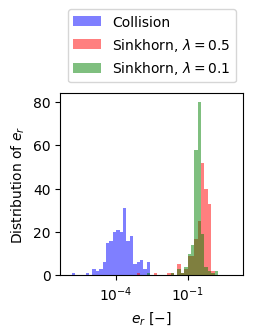

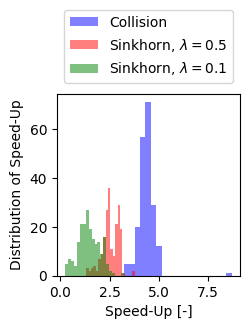

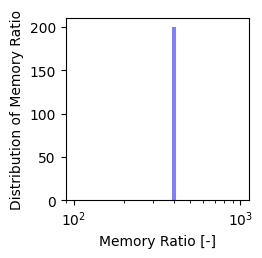

In [184]:
size = 6

rel_errs = np.array( rel_errs )
t_coll = np.array( t_coll )
t_emd = np.array( t_emd )
mem_coll = np.array( mem_coll )
mem_emd = np.array( mem_emd )

rel_errs[rel_errs<1e-15] = 1e-16

xx = [i for i in range(len(rel_errs))]

fig, ax = plt.subplots();
ax.hist(rel_errs, bins=10**np.linspace(-6, 1, 50), color="blue", alpha=0.5, label="Collision")
ax.hist(rel_errs_sinkhorn, bins=10**np.linspace(-6, 1, 50), color="red", alpha=0.5, label="Sinkhorn, $\lambda=0.5$")
ax.hist(rel_errs_sinkhorn2, bins=10**np.linspace(-6, 1, 50), color="green", alpha=0.5, label="Sinkhorn, $\lambda=0.1$")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5))
ax.set_ylabel(r"Distribution of $e_r$")
ax.set_xlabel("$e_r\ [-]$")
ax.set_xscale("log")
fig.set_size_inches(size*cm, size*cm)
plt.savefig('butterfly_dist_rel_error_EMD.pdf',format='pdf', bbox_inches="tight", dpi=300);

#################################3
fig, ax = plt.subplots();
ax.hist(t_emd/t_coll, bins=20, color="blue", alpha=0.5, label="Collision")
ax.hist(t_emd/t_sinkhorn, bins=20, color="red", alpha=0.5, label="Sinkhorn, $\lambda=0.5$")
ax.hist(t_emd/t_sinkhorn2, bins=20, color="green", alpha=0.5, label="Sinkhorn, $\lambda=0.1$")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5))
ax.set_ylabel(r"Distribution of Speed-Up")
ax.set_xlabel("Speed-Up [-]")
fig.set_size_inches(size*cm, size*cm)
plt.savefig('butterfly_dist_speedup_EMD.pdf',format='pdf', bbox_inches="tight", dpi=300);

##################################
fig, ax = plt.subplots();
#_ = ax.hist((mem_emd*1.)/(1.*mem_coll), bins=50, color="blue", alpha=0.5)
_ = ax.hist((mem_emd*1.)/(1.*mem_coll), color="blue", alpha=0.5, bins=10**np.linspace(2, 3, 50))
ax.set_ylabel(r"Distribution of Memory Ratio")
ax.set_xlabel("Memory Ratio [-]")
ax.set_xscale("log")

fig.set_size_inches(size*cm, size*cm)
plt.savefig('butterfly_dist_memratio_EMD.pdf',format='pdf', bbox_inches="tight", dpi=300);


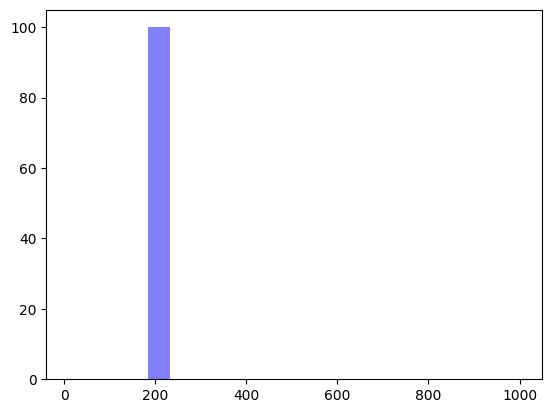

In [172]:
_ = plt.hist((mem_emd*1.)/(1.*mem_coll), color="blue", alpha=0.5, bins=10**np.linspace(1, 3, 20))


In [162]:
mem_coll*1.

array([120536., 120536., 120536., 120536., 120536., 120536., 120536.,
       120536., 120536., 120536., 120536., 120536., 120536., 120536.,
       120536., 120536., 120536., 120536., 120536., 120536., 120536.,
       120536., 120536., 120536., 120536., 120536., 120536., 120536.,
       120536., 120536., 120536., 120536., 120536., 120536., 120536.,
       120536., 120536., 120536., 120536., 120536., 120536., 120536.,
       120536., 120536., 120536., 120536., 120536., 120536., 120536.,
       120536., 120536., 120536., 120536., 120536., 120536., 120536.,
       120536., 120536., 120536., 120536., 120536., 120536., 120536.,
       120536., 120536., 120536., 120536., 120536., 120536., 120536.,
       120536., 120536., 120536., 120536., 120536., 120536., 120536.,
       120536., 120536., 120536., 120536., 120536., 120536., 120536.,
       120536., 120536., 120536., 120536., 120536., 120536., 120536.,
       120536., 120536., 120536., 120536., 120536., 120536., 120536.,
       120536., 1205

In [160]:
mem_emd.shape

(100,)

In [16]:
import time
from lib.collision_wrapper import find_OT_collision as newot
import tracemalloc
tracemalloc.start()

# data0 (213, 256, 256)

dim = 2
Nps = [500, 1000, 2000, 4000] #, 4000]

errors_xy = []

mem_emd  = []
mem_sinkhorn  = []
mem_sinkhorn2  = []
mem_coll = []
ex_time_emd  = []
ex_time_sinkhorn  = []
ex_time_sinkhorn2  = []
ex_time_coll = []
iter_coll_xy = []
hist_coll_w = [[] for i in range(len(Nps))]
err_hist_coll_w = [[] for i in range(len(Nps))]

k=0
navg = 1
for Np in Nps:
  print("Np: ", Np)
  
  k = k + 1

  emd_t = 0
  sinkhorn_t = 0
  sinkhorn2_t = 0
  coll_t = 0
  errors_xy_ = 0
  errors_yz_ = 0
  errors_xz_ = 0
  nt_xy_ = 0
  nt_yz_ = 0
  emd_avgmem = 0.0
  sinkhorn_avgmem = 0.0
  sinkhorn2_avgmem = 0.0
  coll_avgmem = 0.0
  for av in range(navg):
      id_12 = np.random.choice(train_data.shape[0], 2, replace=False)
      x00 = train_data[id_12[0],:Np]
      y00 = train_data[id_12[1],:Np]
      x00 = x00.reshape(x00.shape[0]*x00.shape[1], 1)
      y00 = y00.reshape(y00.shape[0]*y00.shape[1], 1)
    
      ## compute EMD
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_emd = x00.copy(); y_emd = y00.copy();
      start_time = time.time()
      x_emd, y_emd = find_optimal_map_nd(x_emd, y_emd)
      first_size, second_peak = tracemalloc.get_traced_memory()
      emd_avgmem += second_peak - first_peak
      emd_t += time.time() - start_time
      print("EMD Done")
      w_emd_xy = np.mean(np.sum((x_emd-y_emd)**2, axis=1))
      del x_emd, y_emd

      ## compute Sinkhorn
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
      start_time = time.time()
      x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=0.5)
      first_size, second_peak = tracemalloc.get_traced_memory()
      sinkhorn_avgmem += second_peak - first_peak
      sinkhorn_t += time.time() - start_time
      print("Sinkhorn Done")
      del x_sinkhorn, y_sinkhorn
    
      ## compute Sinkhorn
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
      start_time = time.time()
      x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=0.05)
      first_size, second_peak = tracemalloc.get_traced_memory()
      sinkhorn2_avgmem += second_peak - first_peak
      sinkhorn2_t += time.time() - start_time
      print("Sinkhorn2 Done")
      del x_sinkhorn, y_sinkhorn

      ## compute collision based
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_coll = x00.copy(); y_coll = y00.copy();
      start_time = time.time()
      X=np.zeros((2,x00.shape[0],x00.shape[1]))
      X[0,:,:] = x00.copy()
      X[1,:,:] = y00.copy()
      X, dists_coll_xy = newot(X, MinIter=2000, MaxIter=2000, tol = 1e-9, avg_window=20)
      first_size, second_peak = tracemalloc.get_traced_memory()
      coll_avgmem += second_peak - first_peak
      coll_t += time.time() - start_time
      
      x_coll = X[0,:,:]
      y_coll = X[1,:,:]
      hist_coll_w[k-1].append(np.array( (dists_coll_xy)) )
      err_hist_coll_w[k-1].append( abs( np.array( (dists_coll_xy)) - w_emd_xy) )
      print("coll Done")
      del x_coll, y_coll

  iter_coll_xy.append(nt_xy_/navg)

  mem_emd.append(emd_avgmem/navg)
  mem_coll.append(coll_avgmem/navg)
  mem_sinkhorn.append(sinkhorn_avgmem/navg)
  mem_sinkhorn2.append(sinkhorn2_avgmem/navg)
  ex_time_emd.append(emd_t/navg)
  ex_time_coll.append(coll_t/navg)
  ex_time_sinkhorn.append(sinkhorn_t/navg)
  ex_time_sinkhorn2.append(sinkhorn2_t/navg)
  errors_xy.append( errors_xy_/navg )

Np:  500
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
Np:  1000
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
Np:  2000
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done
Np:  4000
EMD Done
Sinkhorn Done
Sinkhorn2 Done
coll Done


sinkhorn: [0.13824677467346191, 0.4541778564453125, 1.6276054382324219, 5.87175989151001]
emd: [0.3613123893737793, 1.3705496788024902, 6.445414304733276, 28.50560998916626]


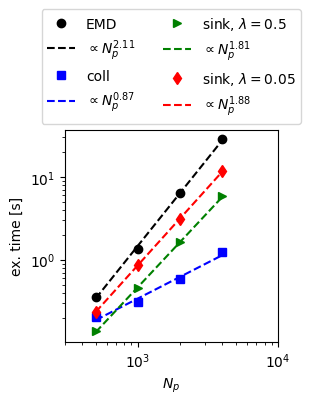

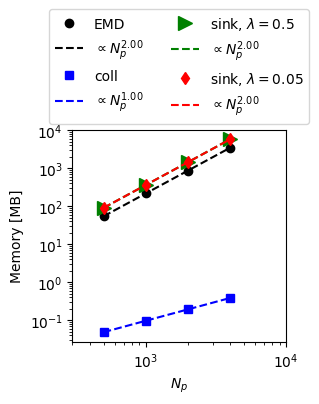

In [20]:
from scipy.stats import linregress

print("sinkhorn:", ex_time_sinkhorn)
print("emd:", ex_time_emd)
def fit_xp(x, y):
    log_x = np.log10(x)
    log_y = np.log10(y)

    slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
    slope_str = f'{slope:.2f}'

    fitted_y = 10**(intercept + slope * log_x)
    return slope, slope_str, fitted_y

###############################################
fig, ax = plt.subplots();

ax.plot(Nps, ex_time_emd, color="black", marker="o", label="EMD", linewidth=0)
slope_emd, slope_emd_str, ex_time_emd_fit_y = fit_xp(Nps, ex_time_emd)
ax.plot(Nps, ex_time_emd_fit_y, label=r'$\propto N_p^{'+slope_emd_str+'}$', color='black', linestyle="--")

ax.plot(Nps, ex_time_coll, color="blue", marker="s", label="coll", linewidth=0)
slope_coll, slope_coll_str, ex_time_coll_fit_y = fit_xp(Nps, ex_time_coll)
ax.plot(Nps, ex_time_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(Nps, ex_time_sinkhorn, color="green", marker=">", label=r"sink, $\lambda=0.5$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, ex_time_sinkhorn_fit_y = fit_xp(Nps, ex_time_sinkhorn)
ax.plot(Nps, ex_time_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='green', linestyle="--")

ax.plot(Nps, ex_time_sinkhorn2, color="red", marker="d", label=r"sink, $\lambda=0.05$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, ex_time_sinkhorn_fit_y = fit_xp(Nps, ex_time_sinkhorn2)
ax.plot(Nps, ex_time_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks([1000,10000],[r'$10^3$',r'$10^4$'])
ax.set_xlim([300,10000])
ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"ex. time [s]")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.6), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('ButterFly_ex_time_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

###############################################
fig, ax = plt.subplots();

ax.plot(Nps, np.array(mem_emd)/1e6, color="black", marker="o", label="EMD", linewidth=0)
slope_emd, slope_emd_str, mem_emd_fit_y = fit_xp(Nps, np.array(mem_emd)/1e6)
ax.plot(Nps, mem_emd_fit_y, label=r'$\propto N_p^{'+slope_emd_str+'}$', color='black', linestyle="--")

ax.plot(Nps, np.array(mem_coll)/1e6, color="blue", marker="s", label="coll", linewidth=0)
slope_coll, slope_coll_str, mem_coll_fit_y = fit_xp(Nps, np.array(mem_coll)/1e6)
ax.plot(Nps, mem_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(Nps, np.array(mem_sinkhorn)/1e6, color="green", marker=">", label=r"sink, $\lambda=0.5$", linewidth=0, markersize=10)
slope_sinkhorn, slope_sinkhorn_str, mem_sinkhorn_fit_y = fit_xp(Nps, np.array(mem_sinkhorn)/1e6)
ax.plot(Nps, mem_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='green', linestyle="--")

ax.plot(Nps, np.array(mem_sinkhorn2)/1e6, color="red", marker="d", label=r"sink, $\lambda=0.05$", linewidth=0)
slope_sinkhorn, slope_sinkhorn_str, mem_sinkhorn_fit_y = fit_xp(Nps, np.array(mem_sinkhorn2)/1e6)
ax.plot(Nps, mem_sinkhorn_fit_y, label=r'$\propto N_p^{'+slope_sinkhorn_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xticks([1000,10000],[r'$10^3$',r'$10^4$'])
ax.set_xlim([300,10000])

ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"Memory [MB]")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.6), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('ButterFly_mem_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);


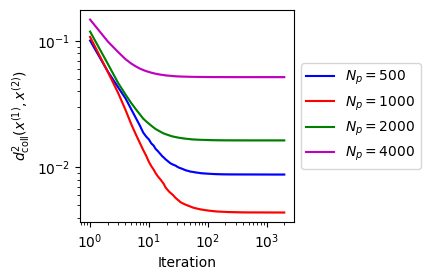

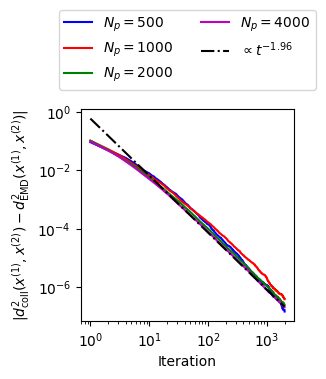

In [21]:
def fit_exp(x, y, test=None):
    log_x = np.log(x)
    log_y = np.log(y)
    if test is None:
        test = log_x
    else:
        test = np.log(test)

    slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
    slope_str = f'{slope:.2f}'

    fitted_y = np.exp(intercept + slope * test)
    return slope, slope_str, fitted_y

fig, ax = plt.subplots();
cls = ["blue", "red", "green", "m", "c", "brown", "gray", "salmon", "blueviolet", "lime", "chocolate"]
for k in range(len(Nps)):
    nmin = 10000000
    for jj in range(len(hist_coll_w[k])):
      if len(hist_coll_w[k][jj]) < nmin:
        nmin = len(hist_coll_w[k][jj])-1
    hist_coll_w_k = np.zeros( (len(hist_coll_w[k]), nmin) )
    for jj in range(len(hist_coll_w[k])):
      for ii in range(nmin):
        hist_coll_w_k[jj,ii] = hist_coll_w[k][jj][ii]
    xx = [i+1 for i in range(nmin)]
    mean_err = np.mean(hist_coll_w_k, axis=0)
    std_err = np.var(hist_coll_w_k,axis=0)**0.5
    ax.plot(xx, mean_err, color=cls[k], markevery=100, label=r"$N_p="+str(Nps[k])+"$")
    plt.fill_between(xx, mean_err-std_err, mean_err+std_err, color=cls[k], alpha=0.2)
    #for av in range(navg):
    #    ax.plot(hist_coll_w[k][av], color=cls[k], marker=markers[av], markevery=100, label=r"$N_p="+str(Nps[k])+"\ rep.\ "+str(av+1)+"$")

t = np.array([i+1 for i in range(len(mean_err))])
ts = np.array([i+1 for i in range(len(mean_err))])
slope, slope_str, fitted_y = fit_exp(t, mean_err, test=ts)
#ax.plot(ts, fitted_y, color="black", linestyle="-.", label=r"$\propto \exp("+slope_str+"t)$")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$d^2_\mathrm{coll}({x}^{(1)},{x}^{(2)})$")

ax.set_xlabel("Iteration")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.set_size_inches(size*cm, size*cm)
#plt.savefig('ButterFly_evol_error_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

fig, ax = plt.subplots();
for k in range(len(Nps)):
    nmin = 10000000
    for jj in range(len(err_hist_coll_w[k])):
      if len(err_hist_coll_w[k][jj]) < nmin:
        nmin = len(err_hist_coll_w[k][jj])-1
    err_hist_coll_w_k = np.zeros( (len(err_hist_coll_w[k]), nmin) )
    for jj in range(len(hist_coll_w[k])):
      for ii in range(nmin):
        err_hist_coll_w_k[jj,ii] = err_hist_coll_w[k][jj][ii]
    xx = [i+1 for i in range(nmin)]
    mean_err = np.mean(err_hist_coll_w_k, axis=0)
    std_err = np.var(err_hist_coll_w_k,axis=0)**0.5
    ax.plot(xx, mean_err, color=cls[k], markevery=100, label=r"$N_p="+str(Nps[k])+"$")
    plt.fill_between(xx, mean_err-std_err, mean_err+std_err, color=cls[k], alpha=0.2)
    #for av in range(navg):
    #    ax.plot(hist_coll_w[k][av], color=cls[k], marker=markers[av], markevery=100, label=r"$N_p="+str(Nps[k])+"\ rep.\ "+str(av+1)+"$")

t = np.array([i+1 for i in range(len(mean_err))])
slope, slope_str, fitted_y = fit_exp(t, mean_err)
ax.plot(t, fitted_y, color="black", linestyle="-.", label=r"$\propto t^{"+slope_str+"}$")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$| d^2_\mathrm{coll}({x}^{(1)},{x}^{(2)}) - d^2_\mathrm{EMD}({x}^{(1)},{x}^{(2)})|$")
ax.set_xlabel("Iteration")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2)

fig.set_size_inches(size*cm, size*cm)
plt.savefig('ButterFly_evol_rel_error_EMD_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

# MNIST

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)

X, y = mnist["data"], mnist["target"]

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [9]:
X0 = np.array(X)/256.

In [139]:
import time
from lib.collision_wrapper import find_OT_collision as newot
import tracemalloc
tracemalloc.start()

X = X0.copy()
rel_errs = []
rel_errs_sinkhorn = []
rel_errs_sinkhorn2 = []
t_emd = []
t_coll = []
t_sinkhorn = []
t_sinkhorn2 = []
mem_emd = []
mem_coll = []
mem_sinkhorn = []
mem_sinkhorn2 = []

Npairs = 1000
ids = np.random.choice(X0.shape[0], 2*Npairs, replace=False)
id1s = []
id2s = []
for i in range(Npairs):
    if i % 100 == 0:
        print("i=", i)
    id1 = ids[2*i]
    id2 = ids[2*1+1]
    id1s.append(id1)
    id2s.append(id2)
    
    x00 = X[id1,:][:,None].copy()
    y00 = X[id2,:][:,None].copy()
    tracemalloc.reset_peak()
    
    first_size, first_peak = tracemalloc.get_traced_memory()
    x_emd = x00.copy(); y_emd = y00.copy();
    start_time = time.time()
    x_emd, y_emd = find_optimal_map_nd(x_emd, y_emd)
    first_size, second_peak = tracemalloc.get_traced_memory()
    mem_emd.append(second_peak - first_peak)
    t_emd.append( time.time() - start_time )
    w_emd_xy = np.mean(np.sum((x_emd-y_emd)**2, axis=1))
    del x_emd, y_emd
    
    tracemalloc.reset_peak()
    first_size, first_peak = tracemalloc.get_traced_memory()
    x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
    start_time = time.time()
    x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=0.5)
    first_size, second_peak = tracemalloc.get_traced_memory()
    mem_sinkhorn.append(second_peak - first_peak)
    t_sinkhorn.append( time.time() - start_time )
    w_sinkhorn_xy = np.mean(np.sum((x_sinkhorn-y_sinkhorn)**2, axis=1))
    del x_sinkhorn, y_sinkhorn

    tracemalloc.reset_peak()
    first_size, first_peak = tracemalloc.get_traced_memory()
    x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
    start_time = time.time()
    x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=0.1)
    first_size, second_peak = tracemalloc.get_traced_memory()
    mem_sinkhorn2.append(second_peak - first_peak)
    t_sinkhorn2.append( time.time() - start_time )
    w_sinkhorn_xy2 = np.mean(np.sum((x_sinkhorn-y_sinkhorn)**2, axis=1))
    del x_sinkhorn, y_sinkhorn
    
    tracemalloc.reset_peak()
    first_size, first_peak = tracemalloc.get_traced_memory()
    x_coll = x00.copy(); y_coll = y00.copy();
    start_time = time.time()
    Xt=np.zeros((2,x00.shape[0],x00.shape[1]))
    Xt[0,:,:] = x00.copy()
    Xt[1,:,:] = y00.copy()
    Xt, dists_coll_xy = newot(Xt, MinIter=1000, MaxIter=10000, tol = 1e-14, avg_window=100)
    first_size, second_peak = tracemalloc.get_traced_memory()
    mem_coll.append(second_peak - first_peak)
    t_coll.append( time.time() - start_time )

    x_coll = Xt[0,:,:]
    y_coll = Xt[1,:,:]
    
    w_coll_xy = np.mean(np.sum((x_coll-y_coll)**2, axis=1))
    del x_coll, y_coll, Xt, x00, y00
        
    rel_errs.append(abs( w_coll_xy - w_emd_xy ) / w_emd_xy)
    rel_errs_sinkhorn.append(abs( w_sinkhorn_xy - w_emd_xy ) / w_emd_xy)
    rel_errs_sinkhorn2.append(abs( w_sinkhorn_xy2 - w_emd_xy ) / w_emd_xy)
    

i= 0
i= 100
i= 200
i= 300
i= 400
i= 500
i= 600
i= 700
i= 800
i= 900


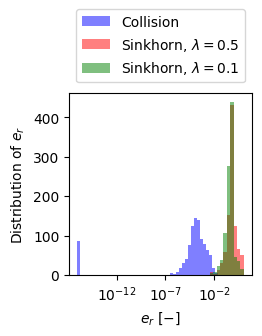

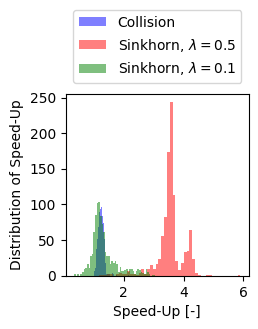

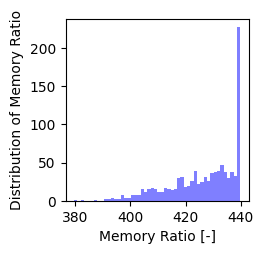

In [143]:
size = 6

rel_errs = np.array( rel_errs )
t_coll = np.array( t_coll )
t_emd = np.array( t_emd )
mem_coll = np.array( mem_coll )
mem_emd = np.array( mem_emd )

rel_errs[rel_errs<1e-15] = 1e-16

xx = [i for i in range(len(rel_errs))]

fig, ax = plt.subplots();
ax.hist(rel_errs, bins=10**np.linspace(-16, -1, 50), color="blue", alpha=0.5, label="Collision")
ax.hist(rel_errs_sinkhorn, bins=10**np.linspace(-16, 1, 50), color="red", alpha=0.5, label="Sinkhorn, $\lambda=0.5$")
ax.hist(rel_errs_sinkhorn2, bins=10**np.linspace(-16, 1, 50), color="green", alpha=0.5, label="Sinkhorn, $\lambda=0.1$")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5))
ax.set_ylabel(r"Distribution of $e_r$")
ax.set_xlabel("$e_r\ [-]$")
ax.set_xscale("log")
fig.set_size_inches(size*cm, size*cm)
plt.savefig('MNIST_dist_rel_error_EMD.pdf',format='pdf', bbox_inches="tight", dpi=300);

#################################3
fig, ax = plt.subplots();
ax.hist(t_emd/t_coll, bins=50, color="blue", alpha=0.5, label="Collision")
ax.hist(t_emd/t_sinkhorn, bins=50, color="red", alpha=0.5, label="Sinkhorn, $\lambda=0.5$")
ax.hist(t_emd/t_sinkhorn2, bins=50, color="green", alpha=0.5, label="Sinkhorn, $\lambda=0.1$")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5))
ax.set_ylabel(r"Distribution of Speed-Up")
ax.set_xlabel("Speed-Up [-]")
fig.set_size_inches(size*cm, size*cm)
plt.savefig('MNIST_dist_speedup_EMD.pdf',format='pdf', bbox_inches="tight", dpi=300);

##################################
fig, ax = plt.subplots();
ax.hist(mem_emd/mem_coll, bins=50, color="blue", alpha=0.5)
ax.set_ylabel(r"Distribution of Memory Ratio")
ax.set_xlabel("Memory Ratio [-]")

fig.set_size_inches(size*cm, size*cm)
plt.savefig('MNIST_dist_memratio_EMD.pdf',format='pdf', bbox_inches="tight", dpi=300);


(array([  1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   2.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   1.,
          0.,   1.,   0.,   1.,   1.,   0.,   1.,   0.,   1.,   0.,   0.,
          0.,   1.,   1.,   4.,   2.,   6.,   0.,   5.,   0.,   2.,   2.,
          3.,   2.,   2.,   6.,   3.,   4.,   1.,   9.,   5.,   4.,   2.,
          3.,   4.,   9.,   6.,  10.,   5.,  10.,  15.,  15.,   5.,  11.,
         13.,  11.,  12.,  13.,   5.,  10.,  15.,  24.,  26.,  13.,  26.,
         14.,  21.,  25.,  20.,  27.,  15.,  11.,  18.,  17.,  25.,  27.,
        439.]),
 array([378.36964692, 378.98470565, 379.59976439, 380.21482312,
        380.82988185, 381.44494058, 382.05999931, 382.67505805,
        383.29011678, 383.90517551, 384.52023424, 385.13529298,
        385.75035171, 386.36541044, 386.98046917, 387.59552791,
        388.21058664, 388.82564537, 389.4407041 , 390.05576283

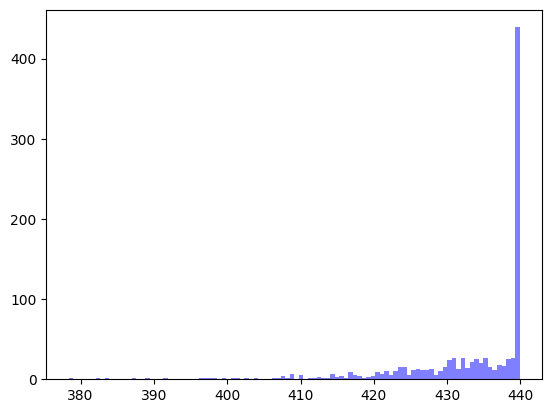

In [117]:
fig, ax = plt.subplots();
ax.hist(mem_emd/mem_coll, bins=100, color="blue", alpha=0.5)


In [45]:
np.var(rel_errs)**0.5

0.012128603765997172